In [1]:
# set your working directory
import os
os.getcwd()
os.chdir('C:/Users/Mark/Documents/GitHub/eos_biomarkers/')

In [2]:
# import packages

# general math, stats, dataframe handling
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import random

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# imputation, random forests things
from itertools import compress
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

# data:
df = pd.read_csv("data/allbatchesclin.csv") # normalized ms data for each protein for each sample w/ log2 abundance
new_df = pd.read_csv('data/leena_proteins_mean2023_nu037fix.csv', index_col = 0) # reshaped dataframe w/ rows for each sample & cols for each protein + some clinical variables
# ^ this differs from the one generated in the code; correct sex info was manually added for nu037.
psmetadata = pd.read_csv('data/ps_metadata_cut.csv') # metadata for each sample
# this differs from ps_metadata.csv in that 1. it lacks chart notes and 2. BP484 & NU125 have been recoded to 1 for prom
mesoscale = pd.read_excel('data/cord_mesoscaledata_12_9_22.xlsx', engine='openpyxl')


In [ ]:
# manual data cleaning- to fix inaccurately coded info

# df = df.drop(df[(df['sample_id']=='NU236') & (df['sample_type']!='Control')].index, axis = 0)
# df.loc[df[df['sample_id'] == 'NU037']['sample_type'].index, 'sample_type'] = 'Control'
# df.loc[df[df['sample_id'] == 'NU236']['sample_type'].index, 'sample_type'] = 'Control'
# df = df[df['sample_id']!='PC']

In [ ]:
#code to reshape the data

# new_df = pd.DataFrame()
# for protein in df['Gene names'].unique():
#     for sampleid in df['sample_id'].unique():
# #         print(protein, sampleid)
#         if df[(df['Gene names']==protein) & (df['sample_id']==sampleid)]['value_log2nb'].isnull().sum() == 0:
#             new_df.at[sampleid, protein] = df[(df['Gene names']==protein) & (df['sample_id']==sampleid)]['value_log2nb'].mean()
#         elif df[(df['Gene names']==protein) & (df['sample_id']==sampleid)]['value_log2nb'].isnull().sum() == 1:
#             new_df.at[sampleid, protein] = df[(df['Gene names']==protein) & (df['sample_id']==sampleid) & (df['value_log2nb'].notnull())]['value_log2nb'].iloc[0]
#         elif df[(df['Gene names']==protein) & (df['sample_id']==sampleid)]['value_log2nb'].isnull().sum() == 2:
#             new_df.at[sampleid, protein] = None
#     print(new_df)
# for sid in new_df.index:
#     for col in ['ga_cat', 'epoch', 'sample_type', 'GA_wks','batch']:
#         print(df[df['sample_id']==sid][col].unique()[0])
# #     for col in ['sample_type']:
#         new_df.loc[sid, col] = df[df['sample_id']==sid][col].unique()[0]

# new_df.to_csv('data/leena_proteins_mean2023.csv')

In [3]:
#incorporating sex into the analysis
merge_df = df.loc[:,['sex','sample_id']]
merge_df = merge_df.drop_duplicates()
new_df['sample_id'] = new_df.index
new_df = pd.merge(new_df, merge_df, how = 'left', on = 'sample_id')


In [4]:
print(new_df[new_df['sample_id'] == 'NU037'])
# NU037 has data for sex, gestational age, etc, in ps_metadata.csv but not in allbatchesclin.csv or in the file that becomes new_df
# I manually copied the data from ps_metadata.csv into the file that becomes new_df, but it's too laborious to fix allbatchesclin
# so it needs manual removal since the discrepancy duplicates it.
new_df = new_df.drop(new_df[(new_df['sample_id'] == 'NU037') & (new_df['sex'].isna())].index, axis=0)

          ALB  HP;HPR   SERPINA1        A2M      IGHG1      IGHG2  IGHG3  \
95  31.732363     NaN  28.198313  27.536863  27.768313  22.924263    NaN   
96  31.732363     NaN  28.198313  27.536863  27.768313  22.924263    NaN   

        APOA1        FGA  FGB  ...  PSME2  CORO1C  CLIC4;CLIC2;CLIC5;CLIC6  \
95  31.524213  25.201763  NaN  ...    NaN     NaN                      NaN   
96  31.524213  25.201763  NaN  ...    NaN     NaN                      NaN   

    ga_cat  epoch  sample_type  GA_wks  batch  sample_id   sex  
95    >=37      4      Control   37.29      2      NU037   NaN  
96    >=37      4      Control   37.29      2      NU037  Male  

[2 rows x 444 columns]


In [5]:
#removing all the controls and presumed sepsis patients
new_df = new_df[new_df['sample_type'] != 'PS_nonclassicEOS']
new_df = new_df[new_df['sample_type'] != 'nonclassicEOS']
new_df = new_df[new_df['sample_type'] != 'Control + degradation assessment sample']
new_df = new_df[new_df['sample_type'] != 'PS_nonclassic EOS']
new_df = new_df[new_df['sample_type'] != 'pooled_control']
new_df = new_df[new_df['sample_type'] != 'PS']

In [6]:
#removing proteins that have over 80% missingness
tmp = new_df.isnull().sum()/new_df.shape[0]
new_df =  new_df.drop(tmp[tmp>0.80].index, axis = 1)

In [8]:
# imputing values for heatmap visualizations (which do not play nice with NAs)
# first: for proteins with less than 30% missingness, use an iterative imputer by sample type
# then: for proteins with greater missingness, just sample from the bottom 10% of values
# the rationale for this approach is that since most missing proteins arose from batch effects,
#   and the batches are 25% each, so proteins with >25-30% missingness are most likely truly non-abundant
#   rather than just not detected in a given batch.
new_df_imp = new_df.copy() #copy it
imputeddf = pd.DataFrame() # this is to save just the imputed things
imp = IterativeImputer(max_iter=10, random_state=0) #define iterative imputer funxion

#for st in ['EOS','Control','PS']:
for st in ['EOS','Control']: #do the following for each sample type:
    tmp = new_df[new_df['sample_type'] == st] #store in tmp only the rows in new_df that have the current sample type
    vals =  tmp.iloc[:, :-7] # grab all cols except the last seven! which are metadata.
    missing = vals.isnull().sum()/vals.shape[0] #for each column, what % are missing?
    keep = missing[missing<0.3].index # names of columns (proteins) where they mostly aren't missing.
    vals_imp = imp.fit_transform(vals.loc[:,keep]) # for the proteins in keep, impute
    vals_imp = pd.DataFrame(vals_imp, index = vals.index, columns = keep) #make it a dataframe
    new_df_imp.loc[vals_imp.index, vals_imp.columns] = vals_imp
    imputeddf = pd.concat([imputeddf, vals_imp]) # save just the imputed things
imputed_labels = new_df.loc[new_df_imp.index, 'sample_type']
imputed_sampleid = new_df.loc[new_df_imp.index, 'sample_id']

#imputing missing values by sampling from bottom 10% of values per protein for proteins not previously dealt with
for prot in new_df.columns[:-7]:
    if not new_df[prot].isnull().any(): 
        continue 
    quantile = new_df[prot].quantile(0.05)
    min_val = new_df[new_df[prot]<quantile][prot].min()
    max_val = new_df[new_df[prot]<quantile][prot].max()
    for idx in new_df_imp[new_df_imp[prot].isnull()][prot].index:
        sample = random.uniform(min_val, max_val) #bottom 10% 
        #sample = 0
        new_df_imp.at[idx,prot] = sample
        imputeddf.at[idx,prot] = sample

In [9]:
# make a df with NAs imputed with zeros, to show how much/what is getting imputed
new_df_zimp = new_df.copy() #copy it 

for prot in new_df.columns[0:-7]:
    for idx in new_df[new_df[prot].isnull()][prot].index:
        new_df_zimp.at[idx,prot] = 0

In [10]:
# remove problematic bits. columns with unexpected strings + NAs
tmp = new_df_imp.isna().sum()
tmp[tmp != 0]
#imp_clean =  new_df_imp.drop(tmp[tmp>0].index, axis = 1).drop(columns=['sample_id', 'Unnamed: 0'])
imp_clean =  new_df_imp.drop(tmp[tmp>0].index, axis = 1).drop(columns=['sample_id'])
# this basically just removes epoch

In [ ]:
##########################
### FIGURES START HERE ###
##########################

In [ ]:
### Figure 1

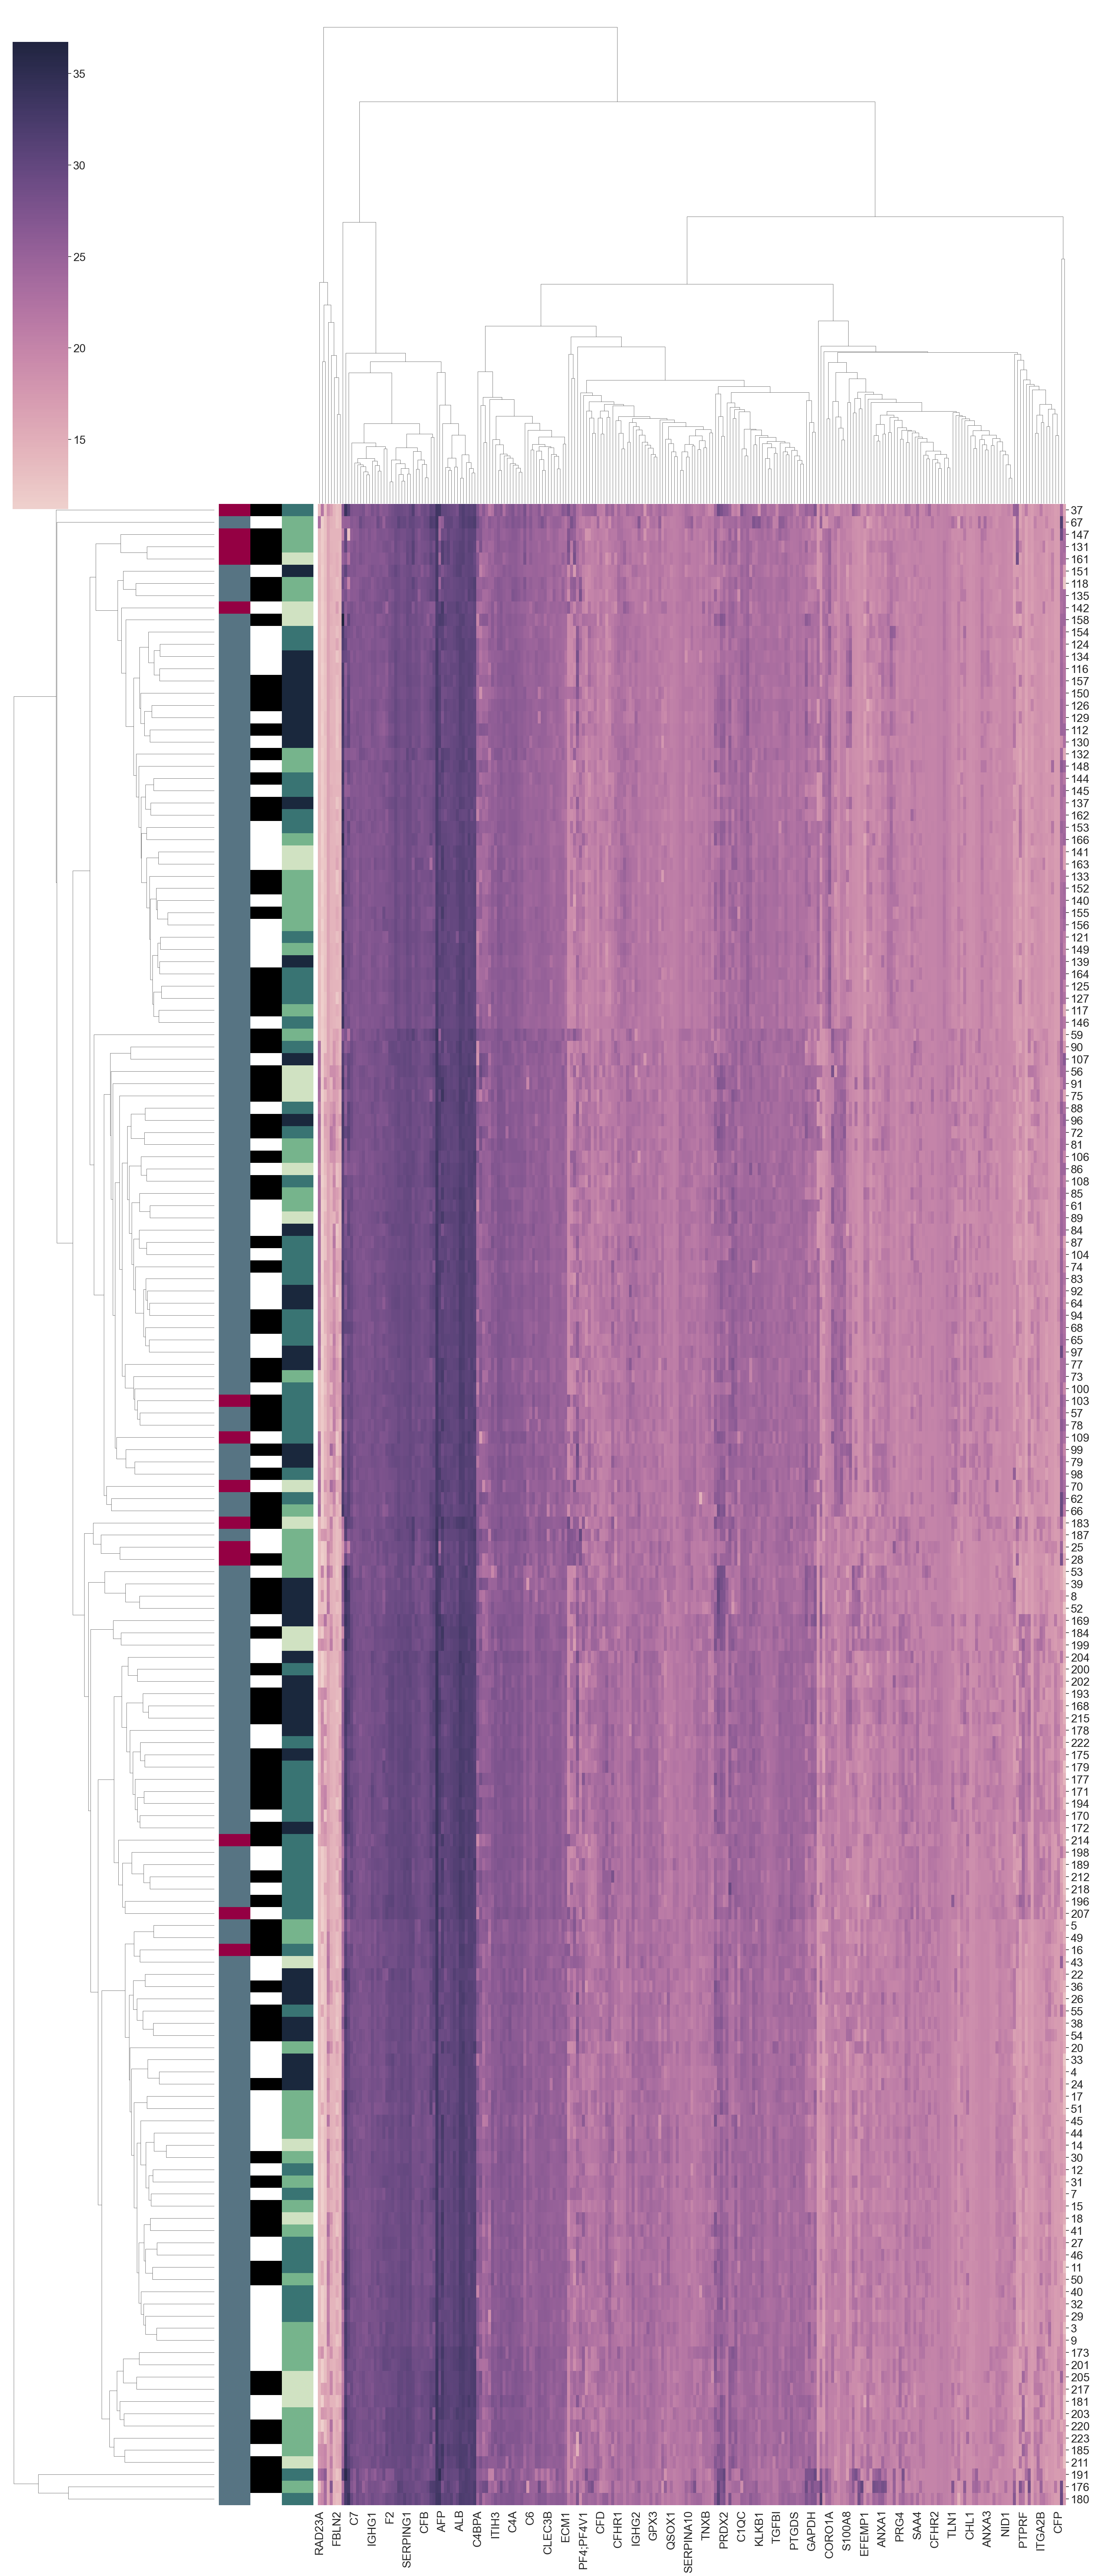

In [11]:
#creating a heatmap and clustering by proteins and samples to see if there are trends associated with sample type, sex or GA weeks
#lut = {'EOS': sns.color_palette("Set3")[3], 'Control': sns.color_palette("Set3")[4], 'PS': 'g'}
#lut = {'EOS': sns.color_palette("husl", 8)[0], 'Control': sns.color_palette("husl", 8)[5], 'PS': 'g'}
lut = {'EOS': '#940043', 'Control': '#577483', 'PS': 'goldenrod'}
fourcol= sns.cubehelix_palette(start=3, rot=-.5, as_cmap=False, n_colors=4) #start =0.5 for pleasant blue, 
lut_ga = {'<28': fourcol[0], '28- <32': fourcol[1], '32-36': fourcol[2], '>=37': fourcol[3], None:'lightpink'}

lut_sex = {'Female': 'white', 'Male': 'black', None:'lightpink'}

row_colors_sample = imp_clean['sample_type'].map(lut)
row_colors_ga = imp_clean['ga_cat'].map(lut_ga)
row_colors_sex = imp_clean['sex'].map(lut_sex)
sns.set(font_scale=2)
testt = sns.cubehelix_palette(start =-0.3, rot=0.5, as_cmap=True, reverse=False)#0.3 for nice purple

sns.clustermap(imp_clean.iloc[:,0:-5], cmap = testt, figsize = [30,70],yticklabels = True,col_cluster = True, row_colors=[row_colors_sample,pd.Series(row_colors_sex).fillna('dimgray'),pd.Series(row_colors_ga).fillna('dimgray')])
plt.savefig('graphs/fig1_heatmap_imputed.eps', format = 'eps',bbox_inches = 'tight')
plt.show()
plt.close()

In [12]:
#write data to a csv for supplementary data file:
f1b_rawdata = new_df_imp.drop(tmp[tmp>0].index, axis = 1)
# Save the dataset to a .csv file
f1b_rawdata.to_csv('extendeddata/f1b_data.csv', index=False)


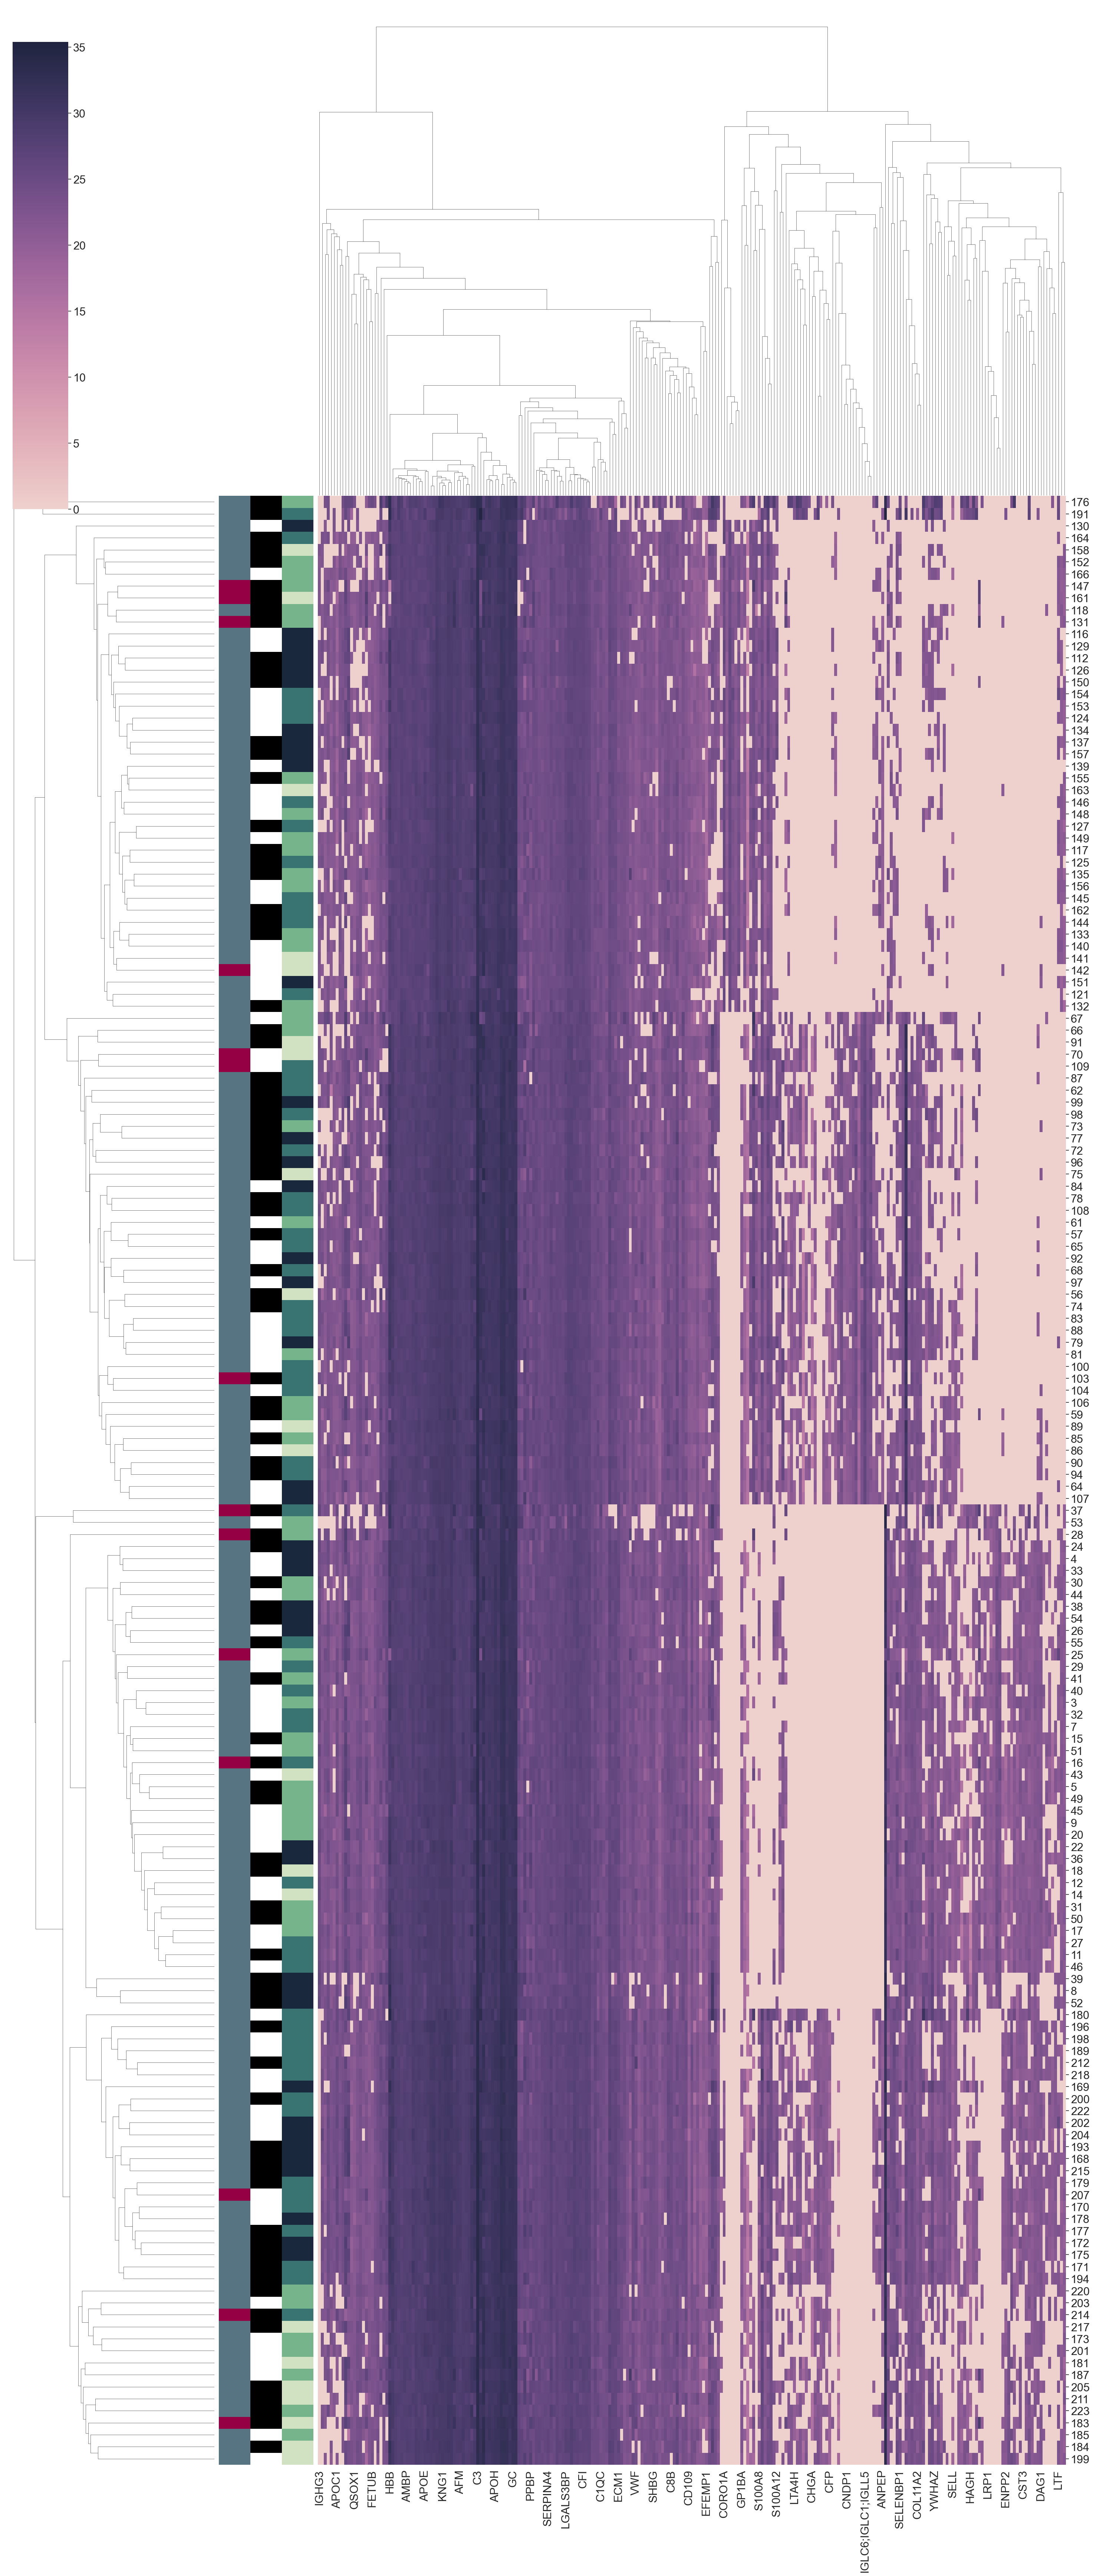

In [13]:
# supplemental figure 1: heatmap with NAs imputed with 0, to show what/how much imputation affects
# remove problematic bits. columns with unexpected strings + NAs
tmpz = new_df_zimp.isna().sum()
#imp_clean =  new_df_imp.drop(tmp[tmp>0].index, axis = 1).drop(columns=['sample_id', 'Unnamed: 0'])
zimp_clean =  new_df_zimp.drop(tmp[tmp>0].index, axis = 1).drop(columns=['sample_id'])

#creating a heatmap and clustering by proteins and samples to see if there are trends associated with sample type, sex or GA weeks
#lut = {'EOS': sns.color_palette("Set3")[3], 'Control': sns.color_palette("Set3")[4], 'PS': 'g'}
#lut = {'EOS': sns.color_palette("husl", 8)[0], 'Control': sns.color_palette("husl", 8)[5], 'PS': 'g'}
lut = {'EOS': '#940043', 'Control': '#577483', 'PS': 'g'}
fourcol= sns.cubehelix_palette(start=3, rot=-.5, as_cmap=False, n_colors=4) #start =0.5 for pleasant blue, 
lut_ga = {'<28': fourcol[0], '28- <32': fourcol[1], '32-36': fourcol[2], '>=37': fourcol[3], None:'lightpink'}

lut_sex = {'Female': 'white', 'Male': 'black', None:'lightpink'}

row_colors_sample = zimp_clean['sample_type'].map(lut)
row_colors_ga = zimp_clean['ga_cat'].map(lut_ga)
row_colors_sex = zimp_clean['sex'].map(lut_sex)
sns.set(font_scale=2)
testt = sns.cubehelix_palette(start =-0.3, rot=0.5, as_cmap=True, reverse=False)#0.3 for nice purple

sns.clustermap(zimp_clean.iloc[:,0:-5], cmap = testt, figsize = [30,70],yticklabels = True,col_cluster = True, row_colors=[row_colors_sample,pd.Series(row_colors_sex).fillna('dimgray'),pd.Series(row_colors_ga).fillna('dimgray')])
plt.savefig('graphs/suppfig1_heatmap_zeros.eps', format = 'eps',bbox_inches = 'tight')

In [14]:
s1_data = new_df
s1_data.to_csv('extendeddata/s1_data.csv', index=False)


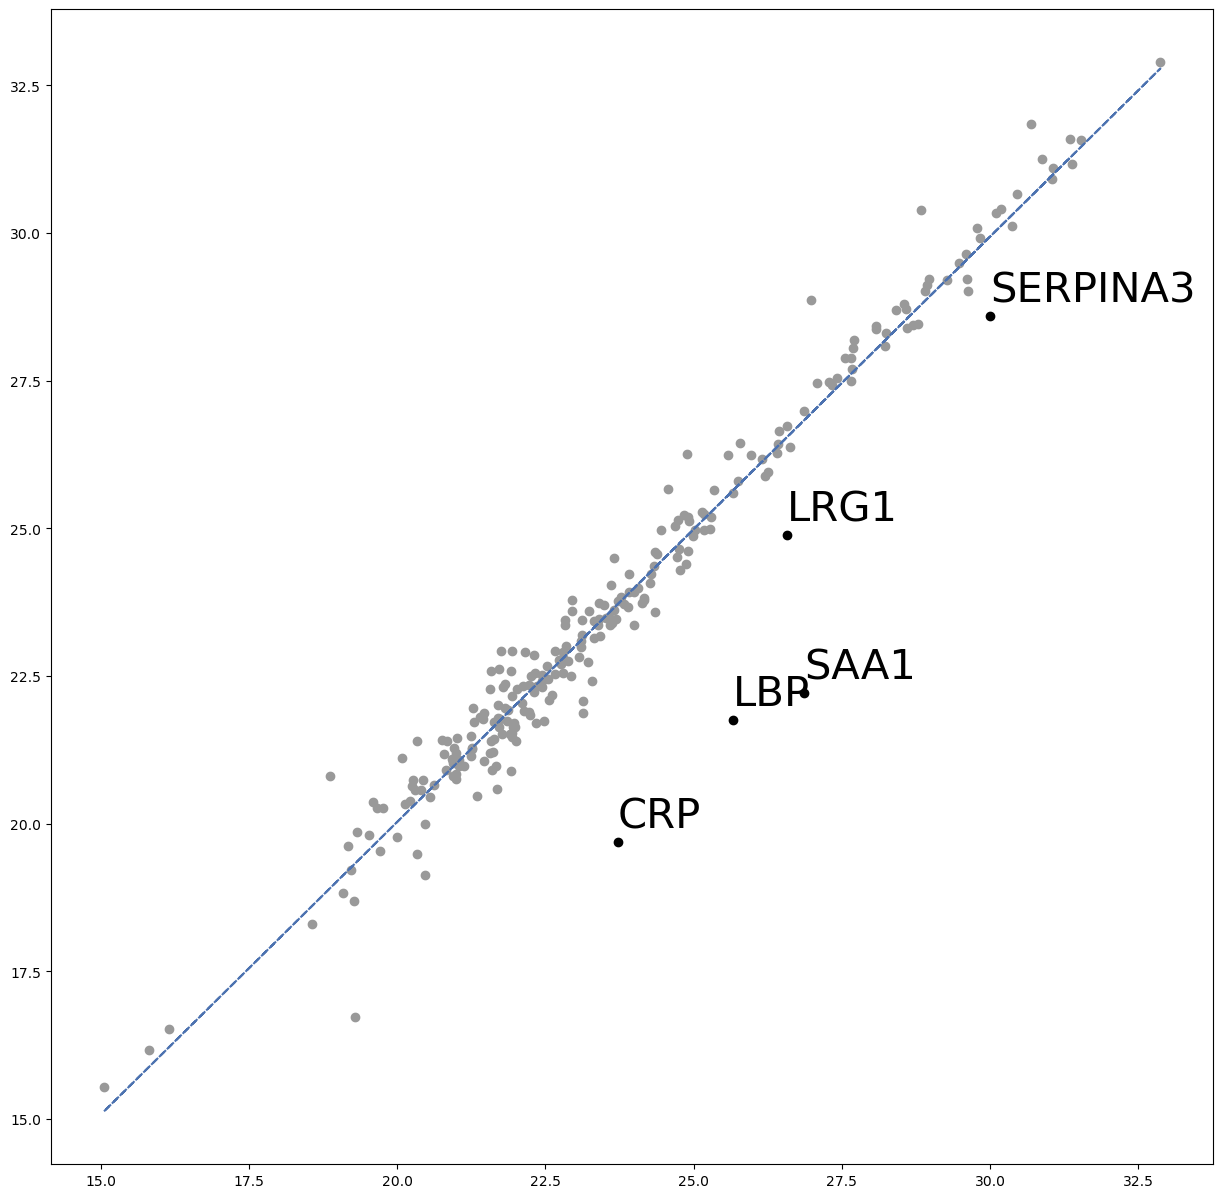

In [15]:
# identifying proteins that are significantly different between EOS and control using mann whitney 
# then correcting for multiple comparisons with bejamini hochberg fdr
# visualizing different proteins by plotting mean of EOS vs mean of Control for each protein
sns.reset_orig()
names = ['ctrl','ps', 'eos']
color = []

genes = []
pvals = []
eosmean = []
ctrlmean = []
psmean = []
foldchange = []

eosfrac = []
ctrlfrac = []
idx = []

#female = new_df[new_df['sex'] != 'Male']
#male = new_df[new_df['sex'] == 'Male']
sensitivity = new_df[new_df['GA_wks'] < 37]
sex = sensitivity
for gene in new_df.columns:
    if gene != 'sample_id' and gene != 'ga_cat' and gene != 'epoch' and gene != 'sample_type' and gene != 'Unnamed: 0' and gene != 'GA_wks' and gene != 'batch' and gene != 'sex':
        ctrl = sex[sex['sample_type'] =='Control'][gene].dropna()
        ps = sex[sex['sample_type'] =='PS'][gene].dropna()
        eos = sex[sex['sample_type'] =='EOS'][gene].dropna()
        if eos.shape[0] == 0 or ctrl.shape[0] == 0:
            pass
        else:
            foldchange.append(np.log2(ctrl.mean()/eos.mean()))
            genes.append(gene)
            mann_whitneypval = stats.mannwhitneyu(eos, ctrl).pvalue
            pvals.append(mann_whitneypval)
            #ttpval = stats.ttest_ind(eos, ctrl, equal_var=False).pvalue
           #ttpval = stats.ttest_ind(eos, ctrl).pvalue
            #pvals.append(ttpval)
            eosmean.append(eos.mean())
            ctrlmean.append(ctrl.mean())
            psmean.append(ps.mean())
            eoslen = eos.shape[0]/14
            contlen = ctrl.shape[0]/150
            eosfrac.append(eoslen)
            ctrlfrac.append(contlen)
            idx.append(abs(eoslen - contlen))
# print(multipletests(pvals, method = 'fdr_bh')[0])

siggenes = list(compress(genes, multipletests(pvals, method = 'fdr_bh')[0]))
z = np.polyfit(eosmean, ctrlmean, 1)
p = np.poly1d(z)

plt.figure(figsize = [15,15])
for g in range(len(genes)):
    gene = genes[g]
    if gene in siggenes:
        plt.scatter(eosmean[g], ctrlmean[g], color = 'black')
        plt.annotate(gene, (eosmean[g], ctrlmean[g]), textcoords = 'offset points', xytext=(0,10), fontsize = 30)
    else:
        plt.scatter(eosmean[g], ctrlmean[g], color = '#999999')
plt.plot(eosmean,p(eosmean),"b", linestyle='dashed')
plt.show()
plt.savefig('graphs/fig1_scatterplot.eps',format = 'eps',bbox_inches = 'tight')

In [16]:
# checking if there are any genes with high missingness that are potentially predictive of EOS


# read in the data again
uncut_df = pd.read_csv('data/leena_proteins_mean2023_nu037fix.csv', index_col = 0) # reshaped dataframe w/ rows for each sample & cols for each protein + some clinical variables

# identifying proteins that are significantly different between EOS and control using mann whitney 
# then correcting for multiple comparisons with bejamini hochberg
# visualizing different proteins by plotting mean of EOS vs mean of Control for each protein
sns.reset_orig()
names = ['ctrl','ps', 'eos']
color = []

genes = []
pvals = []
eosmean = []
ctrlmean = []
psmean = []
foldchange = []

eosfrac = []
ctrlfrac = []
totalfrac = []
idx = []


#female = new_df[new_df['sex'] != 'Male']
#male = new_df[new_df['sex'] == 'Male']
sex = uncut_df
for gene in uncut_df.columns:
    if gene != 'sample_id' and gene != 'ga_cat' and gene != 'epoch' and gene != 'sample_type' and gene != 'Unnamed: 0' and gene != 'GA_wks' and gene != 'batch' and gene != 'sex':
        ctrl = sex[sex['sample_type'] =='Control'][gene].dropna()
        ps = sex[sex['sample_type'] =='PS'][gene].dropna()
        eos = sex[sex['sample_type'] =='EOS'][gene].dropna()
        if eos.shape[0] == 0 or ctrl.shape[0] == 0:
            pass
        else:
            foldchange.append(np.log2(ctrl.mean()/eos.mean()))
            genes.append(gene)
            mann_whitneypval = stats.mannwhitneyu(eos, ctrl).pvalue
            pvals.append(mann_whitneypval)
            #ttpval = stats.ttest_ind(eos, ctrl, equal_var=False).pvalue
           #ttpval = stats.ttest_ind(eos, ctrl).pvalue
            #pvals.append(ttpval)
            eosmean.append(eos.mean())
            ctrlmean.append(ctrl.mean())
            psmean.append(ps.mean())
            eoslen = eos.shape[0]/14
            contlen = ctrl.shape[0]/150
            totallen = (eos.shape[0] + ctrl.shape[0])/164
            eosfrac.append(eoslen)
            ctrlfrac.append(contlen)
            totalfrac.append(totallen)
            idx.append(abs(eoslen - contlen))
# print(multipletests(pvals, method = 'fdr_bh')[0])

siggenes = list(compress(genes, multipletests(pvals, method = 'fdr_bh')[0]))
z = np.polyfit(eosmean, ctrlmean, 1)
p = np.poly1d(z)

dff = pd.DataFrame({
    'genes': genes,
    'pvals': pvals,
    'ctrlmean': ctrlmean,
    'eosmean': eosmean,
    'foldchange': foldchange,
    'pvalcorr': multipletests(pvals, method = 'fdr_bh')[1],
    'eosfrac': eosfrac,
    'ctrlfrac': ctrlfrac,
    'totalfrac': totalfrac,
    'idx': idx
})

dff[(dff['idx'] > 0.2) & (dff['totalfrac'] < 0.2)]

,genes,pvals,ctrlmean,eosmean,foldchange,pvalcorr,eosfrac,ctrlfrac,totalfrac,idx
1,HP;HPR,0.069491,22.140458,22.988262,-0.054212,0.684689,0.428571,0.173333,0.195122,0.255238
117,SAA2,0.370629,22.619873,23.593062,-0.060772,0.952903,0.714286,0.020000,0.079268,0.694286
185,LCN2,0.256622,21.408724,22.263524,-0.056483,0.858974,0.357143,0.093333,0.115854,0.263810


In [17]:
dff.to_csv('extendeddata/f1c_data.csv', index=False)


In [18]:
ps_relevant = mesoscale.loc[mesoscale['CRP_avg_conc_pg/ml'].notna() & (mesoscale['sample_type'] == 'PS'), 'sample_id']
mesoscale_sample = mesoscale.loc[mesoscale['CRP_avg_conc_pg/ml'].notna(), 'sample_id']

In [19]:
# making demographics table

#removing all the controls and presumed sepsis patients
psmetadata = psmetadata[psmetadata['sample_type'] != 'PS_nonclassicEOS']
psmetadata = psmetadata[psmetadata['sample_type'] != 'nonclassicEOS']
psmetadata = psmetadata[psmetadata['sample_type'] != 'Control + degradation assessment sample']
psmetadata = psmetadata[psmetadata['sample_type'] != 'PS_nonclassic EOS']
psmetadata = psmetadata[psmetadata['sample_type'] != 'pooled_control']
#psmetadata = psmetadata[psmetadata['sample_type'] != 'PS']

# fix epoch data type
psmetadata['epoch'] = psmetadata['epoch'].astype(int)

# additionally, not all samples in the proteomics dataset were selected for mesoscale.
# to get accurate data for the presumed sepsis column and to assess whether the subset of controls that were msd'd reflects all controls:
# 1. make lists of which samples were mesoscaled in the different categories
ps_relevant = mesoscale.loc[mesoscale['CRP_avg_conc_pg/ml'].notna() & (mesoscale['sample_type'] == 'PS'), 'sample_id'] # PS & has actual data
mesoscale_sample = mesoscale.loc[mesoscale['CRP_avg_conc_pg/ml'].notna(), 'sample_id'] # the full sample list with MSD data. (check control sampling)
# 2. make test tables with the subsetted controls etc.

#psmetadata_set = psmetadata[psmetadata['sample_id'].isin(mesoscale_sample)]
#psmetadata_set = psmetadata[psmetadata['sample_id'].isin(ps_relevant)]
psmetadata_set = psmetadata[(psmetadata['sample_type'].isin(['Control', 'EOS'])) | ((psmetadata['sample_type'] == 'PS') & (psmetadata['sample_id'].isin(ps_relevant)))]
# define GA_wks categories
bins = [0, 28, 32, 37, np.inf]  # define bin edges
labels = ['<28', '28-<32', '32-<37', '>=37']
psmetadata_set['GA_cat'] = pd.cut(psmetadata_set['GA_wks'], bins=bins, labels=labels, right=False)


# get data for table 1
summary = psmetadata_set.groupby('sample_type').agg({
    'Concentration_ug_uL': ['mean', 'std'],
    'GA_wks': ['mean', 'std', 'median'],
    'GA_cat': [('count_<28', lambda x: (x == '<28').sum()), ('fxn_<28', lambda x: (x == '<28').mean() * 100),
                    ('count_28-<32', lambda x: (x == '28-<32').sum()), ('fxn_28-<32', lambda x: (x == '28-<32').mean() * 100),
                    ('count_32-<37', lambda x: (x == '32-<37').sum()), ('fxn_32-<37', lambda x: (x == '32-<37').mean() * 100),
                    ('count_>=37', lambda x: (x == '>=37').sum()), ('fxn_>=37', lambda x: (x == '>=37').mean() * 100)],
    #'epoch': [('countone', lambda x: (x==1).sum()), ('fxnone', lambda x: (x==1).mean()*100),
    #               ('counttwo', lambda x: (x==2).sum()), ('fxntwo', lambda x: (x==2).mean()*100),
    #               ('countthree', lambda x: (x==3).sum()), ('fxnthree', lambda x: (x==3).mean()*100),
    #               ('countfour', lambda x: (x==4).sum()), ('fxnfour', lambda x: (x==4).mean()*100)],
    'sex': [('countposf', lambda x: (x==1).sum()), ('fxnposf', lambda x: (x==1).mean()*100)],
    'multiplegest': [('countpos', lambda x: (x==1).sum()), ('fxnpos', lambda x: (x==1).mean()*100)],
    'preeclampsia_gesthtn': [('countpos', lambda x: (x==1).sum()), ('fxnpos', lambda x: (x==1).mean()*100)],
    'route_of_del': [('countpos', lambda x: (x==1).sum()), ('fxnpos', lambda x: (x==1).mean()*100)],
    'deliverysum': [('countzero', lambda x: (x==0).sum()), ('fxnzero', lambda x: (x==0).mean()*100),
                   ('countone', lambda x: (x==1).sum()), ('fxnone', lambda x: (x==1).mean()*100),
                   ('counttwo', lambda x: (x==2).sum()), ('fxntwo', lambda x: (x==2).mean()*100)],
    'labor': [('countpos', lambda x: (x==1).sum()), ('fxnpos', lambda x: (x==1).mean()*100)],
    'clinicalchorio': [('countpos', lambda x: (x==1).sum()), ('fxnpos', lambda x: (x==1).mean()*100)],
    'ps_riskcat': [('countpos', lambda x: (x==1).sum()), ('fxnpos', lambda x: (x==1).mean()*100)],
    'PROM':[('countpos', lambda x: (x==1).sum()), ('fxnpos', lambda x: (x==1).mean()*100)]
})

# number of samples per category
sample_counts = psmetadata_set['sample_type'].value_counts().to_frame().T
sample_counts.index = ['Total Samples']


summary = summary.T
summary.columns.name = None
summary = pd.concat([sample_counts, summary])

print(summary)
summary.to_csv('data/table1_summary.csv', index=True)


                                     Control         PS         EOS
Total Samples                     150.000000  53.000000   14.000000
(Concentration_ug_uL, mean)        46.448933  41.390943   40.892857
(Concentration_ug_uL, std)          8.675096   7.235204    7.135939
(GA_wks, mean)                     33.575800  30.922830   30.672857
(GA_wks, std)                       4.461425   3.057336    3.277019
(GA_wks, median)                   33.710000  32.000000   31.070000
(GA_cat, count_<28)                17.000000  12.000000    4.000000
(GA_cat, fxn_<28)                  11.333333  22.641509   28.571429
(GA_cat, count_28-<32)             43.000000  14.000000    4.000000
(GA_cat, fxn_28-<32)               28.666667  26.415094   28.571429
(GA_cat, count_32-<37)             50.000000  27.000000    6.000000
(GA_cat, fxn_32-<37)               33.333333  50.943396   42.857143
(GA_cat, count_>=37)               40.000000   0.000000    0.000000
(GA_cat, fxn_>=37)                 26.666667   0

In [20]:
#new_df_imp['ga_cat'].value_counts()

new_df_imp.groupby('sample_type')['ga_cat'].value_counts(normalize=True)
# manually add back in bp1129 (ps +1 to 28-32)
# not sure why that sample is in psmetadata but not in new_df_imp.


# also +1 to control females
sum((new_df_imp['sex'] =='Female') & (new_df_imp['sample_type'] == 'Control'))

73

In [ ]:
### Figure 2

In [21]:
#testing for differences between each sample type for each protein without imputation

sns.set(font_scale=2)

plt.figure(figsize = [14,4.5])
plt.style.use('default')

genes = ['SAA1','LBP','CRP','LRG1','SERPINA3']
count = 0
pvals_list = []
for p in range(len(genes)):
    prot = genes[p]
    count += 1
    ax = plt.subplot(1,5,count)
    eos = new_df[new_df['sample_type']=='EOS'][prot].dropna()
    ctrl = new_df[new_df['sample_type']=='Control'][prot].dropna()
    ps = new_df[new_df['sample_type']=='PS'][prot].dropna()
    sns.swarmplot(eos, color = '#7cb0c2')
    sns.swarmplot(y = ctrl, x = 1, color = '#940043')
    ax.boxplot(eos, positions = [0], widths = 0.5, labels = ['EOS n = {}'.format(eos.shape[0])])
    ax.boxplot(ctrl, positions = [1], widths = 0.5, labels = ['Control n = {}'.format(ctrl.shape[0])])
    #ax.boxplot(ps, positions = [2], labels = ['PS n = {}'.format(ps.shape[0])])
    #jitters = np.random.normal(0 , 0.04, eos.shape[0])   
    #ax.scatter(jitters, eos, alpha = 0.75)

    #jitters = np.random.normal(1 , 0.04, ctrl.shape[0])   
    #ax.scatter(jitters, ctrl, alpha = 0.75)
    
    #jitters = np.random.normal(2 , 0.04, ps.shape[0])   
    #ax.scatter(jitters, ps, alpha = 0.75)
    pval = mann_whitneypval = stats.mannwhitneyu(eos, ctrl).pvalue
    pvals_list.append(pval)
    if pval < 0.0001:
        pval = '<0.0001'
    ax.set_title('{} adjusted p-value = {}'.format(prot, pval))
    
siggenes = list(compress(genes, multipletests(pvals_list, method = 'fdr_bh')[0]))
tmp = multipletests(pvals_list, method = 'fdr_bh')
plt.savefig('graphs/fig2_boxplot_5prot.eps',format = 'eps',bbox_inches = 'tight')

In [22]:
#save extended data file
f2c_data = new_df[['sample_type', 'sample_id'] + genes]
f2c_data.to_csv('extendeddata/f2c_data.csv', index=False)


In [23]:
# visualize missingness of our five
missingness = new_df.loc[:,['SAA1','LBP','CRP','LRG1','SERPINA3']].isnull().sum()/new_df.shape[0]

plt.bar(x = missingness.index, height = missingness.values)


<BarContainer object of 5 artists>

<Figure size 640x480 with 0 Axes>

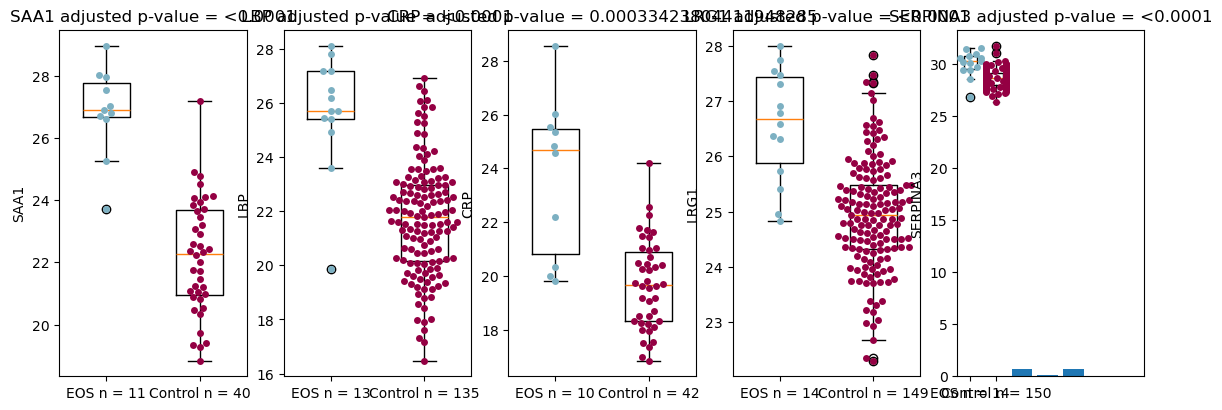

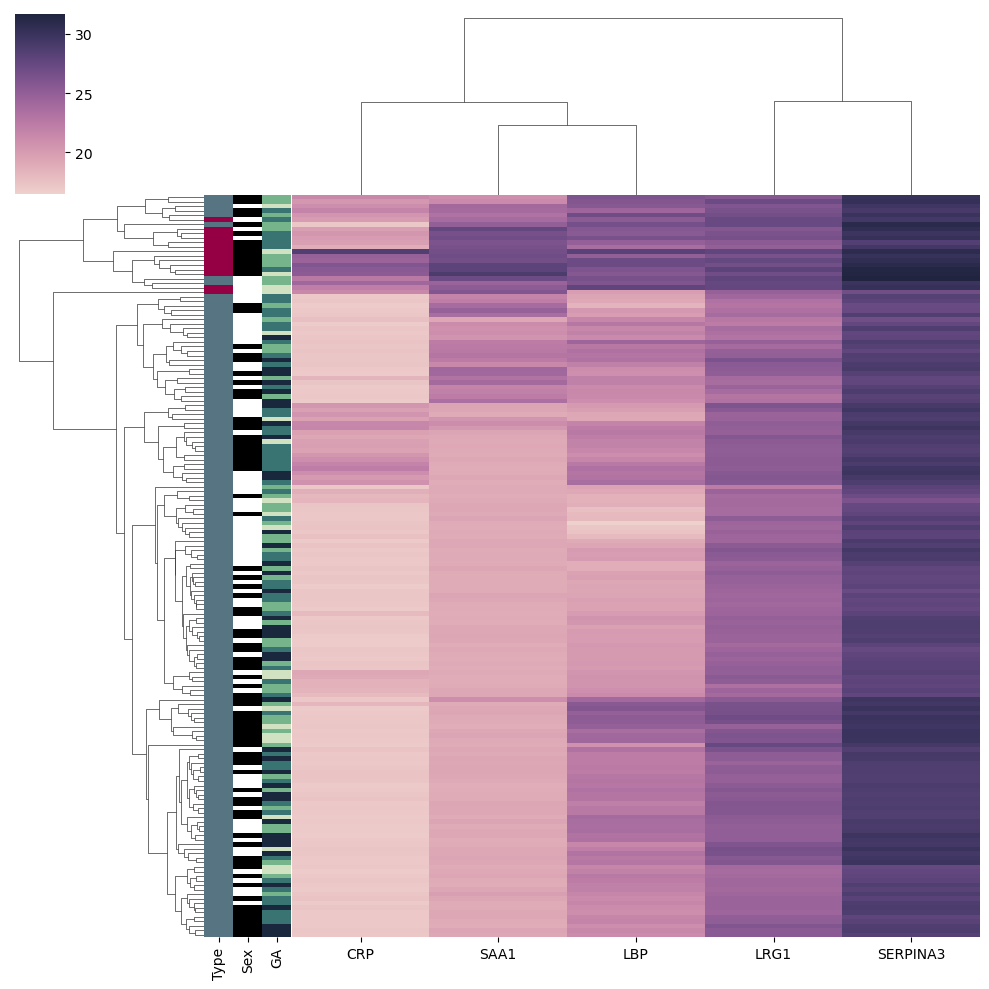

In [24]:
#creating a heatmap and clustering by proteins and samples to see if there are trends associated with sample type, sex or GA weeks
lut = {'EOS': '#940043', 'Control': '#577483', 'PS': '#f4bb3a'}
fourcol= sns.cubehelix_palette(start=3, rot=-.5, as_cmap=False, n_colors=4) #start =0.5 for pleasant blue, 
lut_ga = {'<28': fourcol[0], '28- <32': fourcol[1], '32-36': fourcol[2], '>=37': fourcol[3], None:'lightpink'}
lut_sex = {'Female': 'white', 'Male': 'black', None:'lightpink'}

imputeddf_prot = new_df_imp.loc[:,['SAA1','LBP','CRP','LRG1','SERPINA3']]

row_colors_ga = new_df_imp.loc[imputeddf_prot.index,'ga_cat'].map(lut_ga)
row_colors_sex = new_df_imp.loc[imputeddf_prot.index,'sex'].map(lut_sex)
#imputeddf_prot = imputeddf.loc[:,['SAA1','LBP','CRP','LRG1','SERPINA3']]
#row_colors_ga = new_df.loc[imputeddf_prot.index,'ga_cat'].map(lut_ga)
#row_colors_sex = new_df.loc[imputeddf_prot.index,'sex'].map(lut_sex)


lab_list = [imputed_labels]
data_list = [imputeddf_prot]
lab = lab_list[0]
data = data_list[0]
row_colors = lab.map(lut)

row_colors_combined = pd.DataFrame({
    'Type': row_colors,
    'Sex': row_colors_sex,
    'GA': row_colors_ga
})

testt = sns.cubehelix_palette(start =-0.3, rot=0.5, as_cmap=True, reverse=False)#0.3 for nice purp

sns.clustermap(data, figsize = [10,10],cmap = testt, yticklabels = False,col_cluster = True, row_colors=row_colors_combined)
plt.savefig('graphs/fig2_clustermap.eps', format = 'eps', bbox_inches = 'tight')
plt.show()
plt.close()

In [25]:
data_list

[          SAA1       LBP        CRP      LRG1  SERPINA3
 3    22.605900  23.25175  17.320590  24.87345  27.76065
 4    18.845400  22.80875  16.921624  25.34905  28.94730
 5    23.187750  26.93230  20.468400  26.68990  29.92440
 7    22.360500  24.34570  17.364500  24.76190  28.72050
 8    18.924983  21.20875  17.267184  24.55955  28.94020
 ..         ...       ...        ...       ...       ...
 217  19.034662  24.21121  17.019407  26.00751  29.84091
 218  18.944616  21.52666  16.925934  24.49271  28.72116
 220  19.213366  22.86831  17.001286  25.89571  29.75886
 222  19.353099  22.53201  19.647110  24.85356  29.13056
 223  19.190023  23.56246  17.035588  25.88396  29.89421
 
 [164 rows x 5 columns]]

In [26]:
f2b_data = imputeddf_prot.copy()
f2b_data['sample_type'] = lab
f2b_data['sample_id'] = new_df_imp.loc[imputeddf_prot.index,'sample_id']
f2b_data['ga_cat'] = new_df_imp.loc[imputeddf_prot.index,'ga_cat']
f2b_data['sex'] = new_df_imp.loc[imputeddf_prot.index,'sex']
f2b_data.to_csv('extendeddata/f2b_data.csv', index=False)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


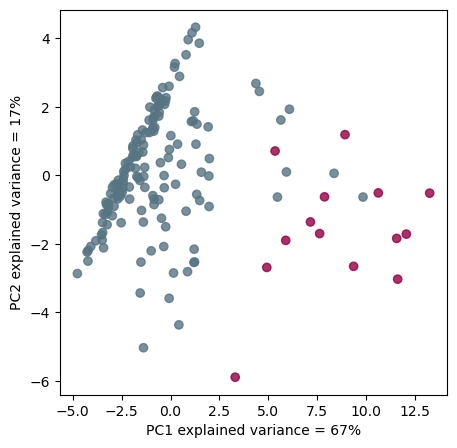

In [27]:
#creating a PCA plot to show if the sample types cluster together
imputeddf_prot = new_df_imp.loc[:, ['SAA1', 'LBP', 'CRP', 'LRG1', 'SERPINA3']]
imputed_labels = new_df_imp['sample_type']

plt.figure(figsize=(5, 5))
pca = PCA(n_components=2)
x_new = pca.fit_transform(imputeddf_prot)
row_colors = imputed_labels.map(lut)

y = row_colors
plt.scatter(x_new[:,0], x_new[:,1], color = row_colors, alpha = 0.8)
plt.xlabel('PC1 explained variance = {}%'.format(int(pca.explained_variance_ratio_[0]*100)))
plt.ylabel('PC2 explained variance = {}%'.format(int(pca.explained_variance_ratio_[1]*100)))
plt.savefig('graphs/fig2_pca.eps', bbox_inches = 'tight')
plt.show()


In [28]:
f2a_data = pd.DataFrame(
    data=x_new,
    columns=['PC1', 'PC2']  
)
f2a_data['sample_type'] = new_df_imp['sample_type'].values
f2a_data['sample_id'] = new_df_imp['sample_id'].values

f2a_data.to_csv('extendeddata/f2a_data.csv', index=False)


In [ ]:
### Figure 3.

In [30]:
# first, process mesoscale data
metadata = psmetadata
idx = mesoscale[mesoscale['sample_id'].isin(metadata[metadata['epoch']==4]['sample_id'])].index
mesoscale = mesoscale.drop(idx, axis = 0)
metadata = metadata[metadata['epoch']!=4]

#renaming column names
for c in ['SAA_avg_conc_pg/ml','CRP_avg_conc_pg/ml','LBP_avg_conc_pg/ml']:
    mesoscale = mesoscale.rename({c:c.split('/')[0]}, axis = 1)
    mesoscale['{}_log'.format(c.split('/')[0])] = np.log(mesoscale[c.split('/')[0]])

#pulling out the metadata keys
metadata_keys = metadata.iloc[0,:]


#dropping controls and other PS weird sample types
for drop in ['pooled_control','nonclassicEOS','Control + degradation assessment sample','PS_nonclassicEOS','PS_nonclassic EOS']:
    mesoscale = mesoscale[mesoscale['sample_type']!=drop]
    metadata = metadata[metadata['sample_type']!=drop]

for c in ['preeclampsia_gesthtn', 'deliverysum', 'route_of_del', 'labor',
       'clinicalchorio', 'PROM']:
#     print(metadata[metadata[c].isnull()])
    metadata[c] = metadata[c].astype(int)

#incorporating metadata into the main dataset
mesoscale = pd.merge(mesoscale, metadata, how = 'left', on = 'sample_id')
mesoscale = mesoscale[mesoscale['mesoscale_plate_number'].notnull()]

#imputation of missing values with 0 due to mesoscales ultra sensitive characteristics

tmpdf = mesoscale.loc[:,['CRP_avg_conc_pg_log','SAA_avg_conc_pg_log', 'LBP_avg_conc_pg_log']].fillna(0)
tmpdf.index = mesoscale['sample_id']
mesoscale.index = mesoscale['sample_id']

lut = {'EOS': '#940043', 'Control': '#bae4e6', 'PS': '#f4bb3a'}
row_colors = mesoscale['sample_type_x'].map(lut)
testt = sns.cubehelix_palette(start =-0.3, rot=0.5, as_cmap=True, reverse=False)#0.3 for nice purp


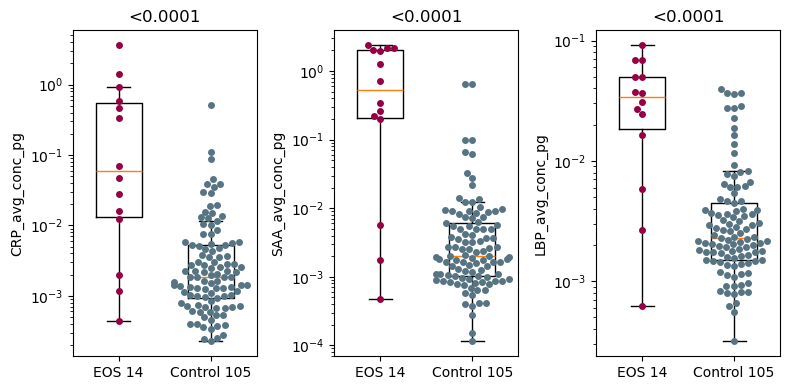

In [31]:
#boxplot of the 3 proteins split by cohort (control vs EOS)
sns.set(font_scale=2)
plt.style.use('default')

plt.figure(figsize = [8,4])
genes = ['CRP_avg_conc_pg',
'SAA_avg_conc_pg',
'LBP_avg_conc_pg']

ctrl_medians = {}
eos_medians = {}

count = 0
pvals_list = []
PG_TO_MG = 1e-9

for p in range(len(genes)):
    prot = genes[p]
    count += 1
    ax = plt.subplot(1,3,count)
    eos = (mesoscale[mesoscale['sample_type_y']=='EOS'][prot].dropna()) * PG_TO_MG
    ctrl = (mesoscale[mesoscale['sample_type_y']=='Control'][prot].dropna()) * PG_TO_MG
    ctrl_medians[prot] = ctrl.median()
    eos_medians[prot] = eos.median()

    sns.swarmplot(eos, color = '#940043')
    sns.swarmplot(y = ctrl, x = 1, color = '#577483')    
    ax.boxplot(eos, positions = [0], widths = 0.5, labels = ['EOS {}'.format(eos.shape[0])], showfliers = False)
    ax.boxplot(ctrl, positions = [1], widths = 0.5, labels = ['Control {}'.format(ctrl.shape[0])], showfliers = False)
    #jitters = np.random.normal(0 , 0.04, eos.shape[0])   
    #ax.scatter(jitters, eos, alpha = 0.75, color = 'r')

    #jitters = np.random.normal(1 , 0.04, ctrl.shape[0])   
    #ax.scatter(jitters, ctrl, alpha = 0.75, color = 'b')
    plt.yscale('log')

    pval = mann_whitneypval = stats.mannwhitneyu(eos, ctrl).pvalue
    pvals_list.append(pval)
    if pval < 0.0001:
        pval = '<0.0001'
    ax.set_title('{}'.format(pval))


# siggenes = list(compress(genes, multipletests(pvals_list, method = 'fdr_bh')[0]))
tmp = multipletests(pvals_list, method = 'fdr_bh')
plt.tight_layout()

plt.savefig('graphs/fig3_msd_beeswarms_log_WBIO.eps', format='eps', bbox_inches='tight')
plt.show()
plt.close()

In [32]:
f3b_data = mesoscale[['sample_type_y', 'sample_id'] + genes].copy()
#f3b_data[genes] = f3b_data[genes] * PG_TO_MG
f3b_data.to_csv('extendeddata/f3b_data.csv', index=False)


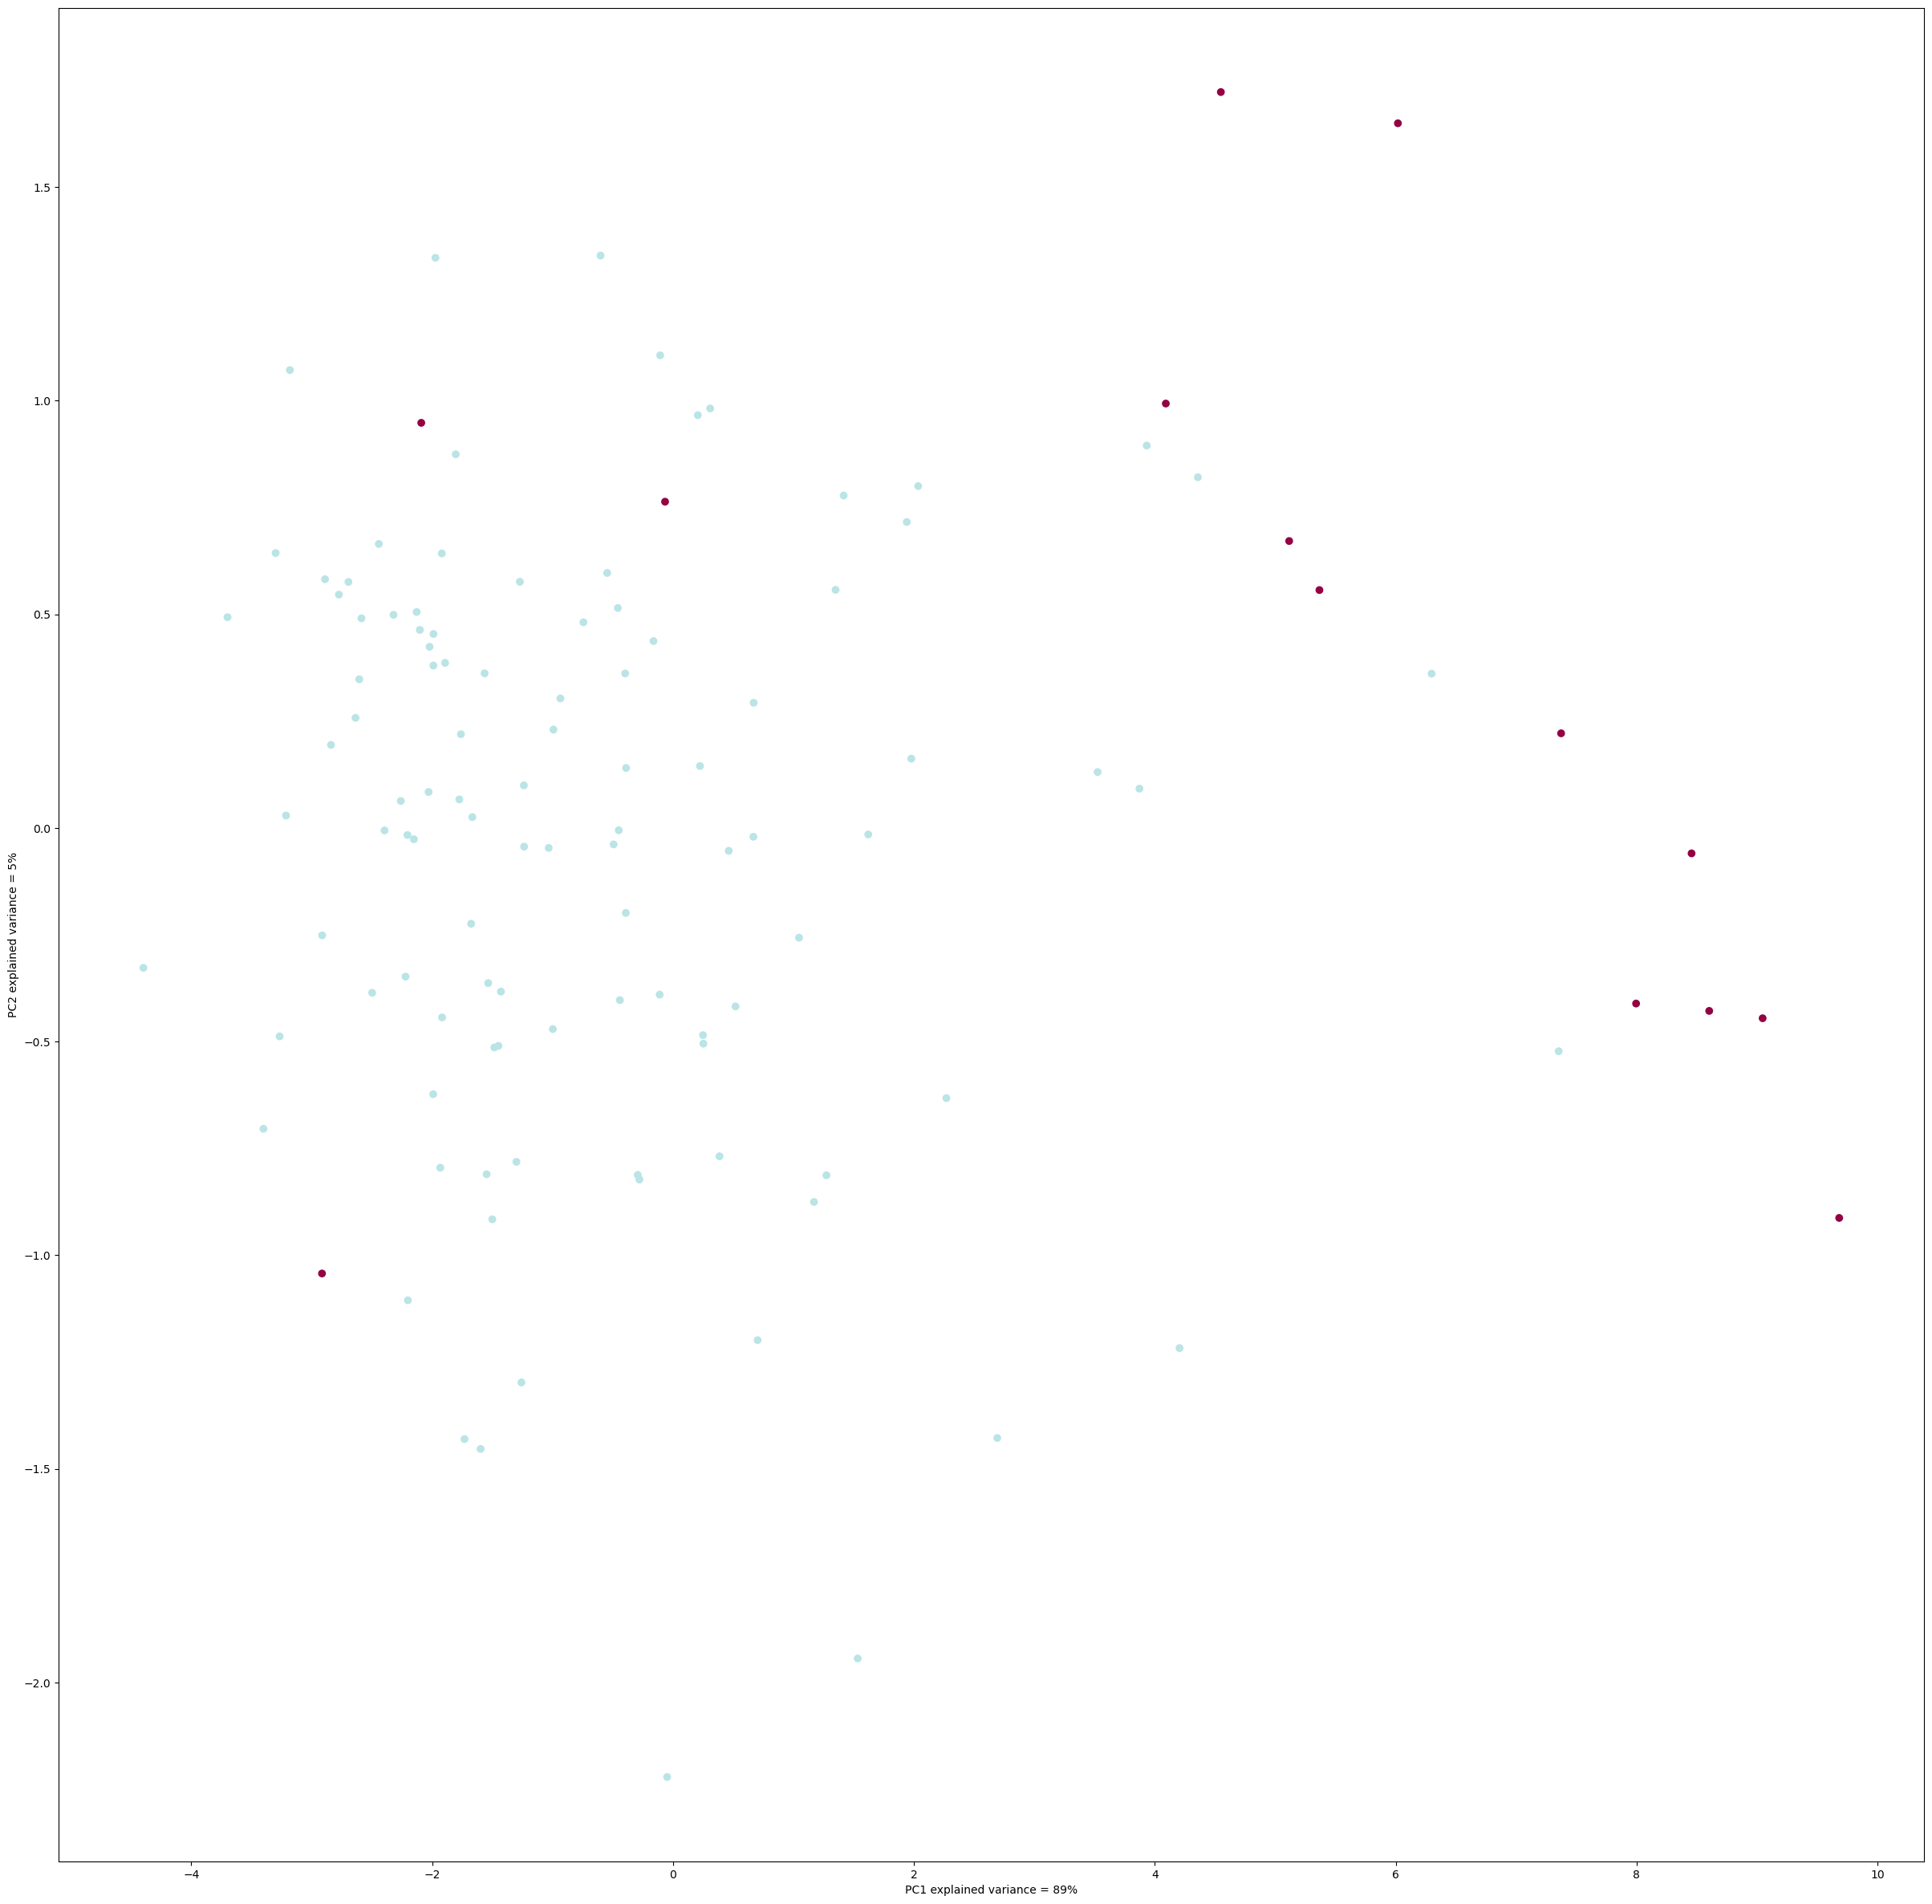

In [33]:
#PCA plot of just the eos/control
ok = ['EOS', 'Control']
sample_ids = mesoscale[mesoscale['sample_type_x'].isin(ok)]['sample_id'].tolist()

#plottem = x_new_df[x_new_df['sample_id'].isin(sample_ids)]
#plottem = x_new_df[x_new_df.index.isin(ok)]

interest = tmpdf[tmpdf.index.isin(sample_ids)]

sns.set(font_scale=2)

plt.figure(figsize = [30,30])
plt.style.use('default')
pca = PCA(n_components=2)
x_new = pca.fit_transform(interest)
x_new_df = pd.DataFrame(x_new)
x_new_df.index = interest.index

filtered_colors = [row_colors[list(tmpdf.index).index(idx)] for idx in interest.index]

plt.scatter(x_new_df.iloc[:,0], x_new_df.iloc[:,1], color = filtered_colors)
plt.xlabel('PC1 explained variance = {}%'.format(int(pca.explained_variance_ratio_[0]*100)))
plt.ylabel('PC2 explained variance = {}%'.format(int(pca.explained_variance_ratio_[1]*100)))


plt.savefig('graphs/fig3_pca.eps',format = 'eps',bbox_inches = 'tight')
plt.show()
plt.close()

In [34]:
f3c_data = x_new_df.copy()
f3c_data['sample_id'] = f3c_data.index
f3c_data['sample_type'] = mesoscale.set_index('sample_id').loc[f3c_data.index, 'sample_type_x']
f3c_data.to_csv('extendeddata/f3c_data.csv', index=True)


In [ ]:
### Figure 4.

In [35]:
# Logistic regressions

import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score


mesoscale_nops = mesoscale[mesoscale['sample_type_x']!='PS']
mesoscale_nops = mesoscale_nops.dropna(subset=['sex'])
mesoscale_nops['sex'] = mesoscale_nops['sex'].astype(int)

mesoscale_nops = mesoscale_nops.dropna(subset=['sex'])
mesoscale_nops['sex'] = mesoscale_nops['sex'].astype(int)

mesoscale_nops['sample_type_x'] = mesoscale_nops['sample_type_x'].map({'EOS':1, 'Control':0})

def calculate_classification_metrics(y_true, y_pred):
    """Calculate accuracy, sensitivity, and specificity."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # Also known as recall
    specificity = tn / (tn + fp)
    
    return accuracy, sensitivity, specificity, tp, fp, tn, fn

# Define the features
cat = ['SAA_avg_conc_pg', 'LBP_avg_conc_pg', 'CRP_avg_conc_pg', 'sex', 'preeclampsia_gesthtn', 'deliverysum', 'multiplegest', 'PROM', 'clinicalchorio', 
       'labor', 'route_of_del', 'Concentration_ug_uL']
# Initialize an empty list to store results
results_list = []

# Run logistic regression for each feature
for feature in cat:
    # Create the formula
    formula = f'sample_type_x ~ GA_wks + sex + {feature}'
    #formula = f'sample_type_x ~ GA_wks + sex'
    
    try:
        # Fit the model
        model = smf.logit(formula, data=mesoscale_nops)
        result = model.fit(disp=False)
        
        # Get predicted probabilities
        y_pred_proba = result.predict(mesoscale_nops)
        # Convert probabilities to binary predictions using 0.5 threshold
        y_pred = (y_pred_proba >= 0.5).astype(int)
        # Get true values
        y_true = mesoscale_nops['sample_type_x']
        
        # Calculate classification metrics
        accuracy, sensitivity, specificity, tp, fp, tn, fn = calculate_classification_metrics(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)

        # Store results in a dictionary
        result_dict = {
            'feature': feature,
            'formula': formula,
            'AIC': result.aic,
            'BIC': result.bic,
            'log_likelihood': result.llf,
            'pseudo_r2': result.prsquared,
            'converged': result.mle_retvals['converged'],
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'auc': auc,
            'tp': tp,
            'fp': fp,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
        }
        
        results_list.append(result_dict)
        
    except Exception as e:
        print(f"Error fitting model for feature {feature}: {str(e)}")


all_results = pd.DataFrame(results_list)
numeric_columns = ['AIC', 'BIC', 'log_likelihood', 'pseudo_r2', 
                  'accuracy', 'sensitivity', 'specificity', 'auc']
all_results[numeric_columns] = all_results[numeric_columns].round(3) #round

all_results.to_csv('data/summary_onefeature.csv', index=False)

print("\nSummary of Classification Metrics:")
print(all_results[['feature', 'accuracy', 'sensitivity', 'specificity']].describe())


Summary of Classification Metrics:
        accuracy  sensitivity  specificity
count  12.000000    12.000000    12.000000
mean    0.894667     0.148917     0.994333
std     0.019171     0.220744     0.009614
min     0.882000     0.000000     0.971000
25%     0.882000     0.000000     0.990000
50%     0.882000     0.000000     1.000000
75%     0.912000     0.429000     1.000000
max     0.924000     0.500000     1.000000


C:\Users\Mark\anaconda3\envs\sepsis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# Random forests downstream...
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels
from scipy.stats import mannwhitneyu, wilcoxon
import itertools
from sklearn.preprocessing import StandardScaler
from numpy import inf
import math
from statsmodels.stats.multitest import multipletests
from matplotlib.pyplot import cm
from sklearn.cluster import AgglomerativeClustering
from itertools import combinations

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [37]:
#filtering out the presumed sepsis group
ps_notlab = mesoscale[(mesoscale['sample_type_y']=='PS')]

ps_notlab = ps_notlab[ps_notlab['CRP_avg_conc_pg'].notnull()]

In [38]:
#training a random forest model to classify EOS vs Control using the mesoscale data
#10 total runs with 50% training, 50% testing data.
#50% training data is further subjected to gridsearch cross validation to get the best model
f1_list = []
tpr_list = []
fpr_list = []
roc_list = []
precision_list = []
recall_list = []
tp_list = []
fp_list = []
tn_list = []
fn_list = []

df = mesoscale[(mesoscale['sample_type_y']=='Control') | (mesoscale['sample_type_y']=='EOS') ]
df = df[df['CRP_avg_conc_pg'].notnull()]

df['sample_type_y'].value_counts()
ps_notlab = mesoscale[(mesoscale['sample_type_y']=='PS')]
psmissing = ps_notlab[ps_notlab['CRP_avg_conc_pg'].isnull()]
ps_notlab = ps_notlab[ps_notlab['CRP_avg_conc_pg'].notnull()]
ps = mesoscale[(mesoscale['sample_type_y']=='PS')].loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg']]

Xbio = df.loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg', 'GA_wks', 'sex', 'multiplegest', 'preeclampsia_gesthtn', 'route_of_del', 'labor', 'deliverysum', 'clinicalchorio', 'PROM', 'Concentration_ug_uL']]
Xclin = df.loc[:,['GA_wks', 'sex', 'multiplegest', 'preeclampsia_gesthtn', 'route_of_del', 'labor', 'clinicalchorio', 'deliverysum', 'PROM', 'Concentration_ug_uL']]
Y = df['sample_type_y']

# function to train and evaluate the model
def train_rf(X, Y):
    f1_list, tpr_list, fpr_list, roc_list, precision_list, recall_list, f1_listbin, f1_listmacro, f1_listweighted, f1_listsamples = [], [], [], [], [], [], [], [], [], []
    
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
    
    for train_index, test_index in sss.split(X, Y):
        rf = RandomForestClassifier(class_weight={'EOS': 10, 'Control': 1}, random_state=42)
        parameters = {
            'n_estimators': [50, 100],
            'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy'],
            'max_depth': [4, 5, 6],
            'min_samples_leaf': [2, 3]
        }
        print('im going into the gridsearch')
        clf = GridSearchCV(rf, parameters)
        clf.fit(X.iloc[train_index, :], Y.iloc[train_index])
        print('im done gridsearching')
        y_pred = clf.predict(X.iloc[test_index, :])
        y_pred_probab = clf.predict_proba(X.iloc[test_index, :])[:, 1]
        y_true = Y.iloc[test_index]
        
        # Calculate metrics
        #f1_list.append(f1_score(y_true, y_pred, average='micro'))
        f1_listbin.append(f1_score(y_true, y_pred, average='binary', pos_label='EOS'))
        #f1_listmacro.append(f1_score(y_true, y_pred, average = 'macro'))
        #f1_listweighted.append(f1_score(y_true, y_pred, average = 'weighted'))
        precision_list.append(precision_score(y_true, y_pred, pos_label='EOS'))
        recall_list.append(recall_score(y_true, y_pred, pos_label='EOS'))
        fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_probab, pos_label='EOS')
        roc_auc = metrics.auc(fpr, tpr)
        roc_list.append(roc_auc)
        cm = confusion_matrix(y_true, y_pred, labels=['EOS', 'Control'])
        tp = cm[0, 0]
        fp = cm[0, 1]
        tn = cm[1, 1]
        tpr_list.append(tp / (tp + fp) if tp + fp > 0 else 0)
        fpr_list.append(fp / (fp + tn) if fp + tn > 0 else 0)
    
    return fpr_list, precision_list, recall_list, roc_list, f1_listbin

# Run for both sets of variables
metricsbio = train_rf(Xbio, Y)
metricsclin = train_rf(Xclin, Y)

im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im done gridsearching
im going into the gridsearch
im

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


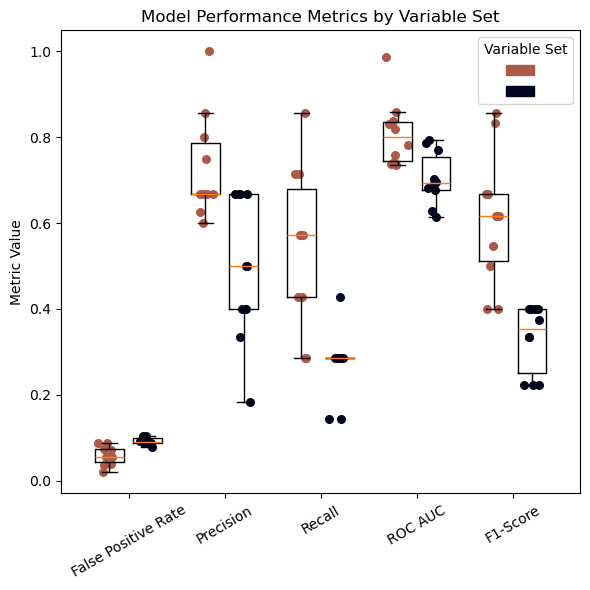

In [39]:
import matplotlib.patches as mpatches
# Unpack metrics
names = ['False Positive Rate', 'Precision', 'Recall', 'ROC AUC', 'F1-Score']

metrics_list = [metricsbio, metricsclin]
# Plotting results with black and cyan dots
plt.figure(figsize=[6, 6])

# Define colors for each variable set
colors = ['#AB5A47', '#000521']

for i, metrics in enumerate(metrics_list):
    positions = np.arange(len(names)) + i * 0.4 -0.2 # Shift positions for side-by-side boxplots
    
    for l, metrica in enumerate(metrics):
        plt.boxplot(metrica, positions=[positions[l]], widths=0.3, showfliers=False)
        jitters = np.random.normal(0, 0.05, len(metrica))  # Add jitter for scatter points
        
        # Scatter points with specified colors
        for j in range(len(metrica)):
            plt.scatter(positions[l] + jitters[j], metrica[j], color=colors[i], s=30)

# Custom ticks and legends
plt.xticks(ticks=np.arange(len(names)), labels=names, rotation=30)
legend_handles = [
    mpatches.Patch(color='#AB5A47'),
    mpatches.Patch(color='#000521')
]
plt.legend(handles=legend_handles, title='Variable Set')
plt.title('Model Performance Metrics by Variable Set')
plt.ylabel('Metric Value')
plt.tight_layout()

# Save the plot
plt.savefig('graphs/fig4_comparison_boxplots.eps', format='eps', bbox_inches='tight')
plt.show()


In [40]:
metricsbio_df = pd.DataFrame(metricsbio, index = names).T
metricsclin_df = pd.DataFrame(metricsclin, index = names).T
metricsbio_df['source'] = 'metricsbio'
metricsclin_df['source'] = 'metricsclin'
metrics_df = pd.concat([metricsbio_df, metricsclin_df], ignore_index=True)
metrics_df.to_csv('extendeddata/f4a_data.csv', index=False)

In [ ]:
metrics_df

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix
import sklearn.metrics as metrics

#training a random forest model to classify EOS vs Control using the mesoscale data
#10 total runs with 50% training, 50% testing data.
#50% training data is further subjected to gridsearch cross validation to get the best model
f1_list = []
tpr_list = []
fpr_list = []
roc_list = []
precision_list = []
recall_list = []
tp_list = []
fp_list = []
tn_list = []
fn_list = []

df = mesoscale[(mesoscale['sample_type_y']=='Control') | (mesoscale['sample_type_y']=='EOS') ]
df = df[df['CRP_avg_conc_pg'].notnull()]

df['sample_type_y'].value_counts()
ps_notlab = mesoscale[(mesoscale['sample_type_y']=='PS')]
psmissing = ps_notlab[ps_notlab['CRP_avg_conc_pg'].isnull()]
ps_notlab = ps_notlab[ps_notlab['CRP_avg_conc_pg'].notnull()]
ps = mesoscale[(mesoscale['sample_type_y']=='PS')].loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg']]

Xbio = df.loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg', 'GA_wks', 'sex', 'multiplegest', 'preeclampsia_gesthtn', 'route_of_del', 'labor', 'deliverysum', 'clinicalchorio', 'PROM', 'Concentration_ug_uL']]
Xclin = df.loc[:,['GA_wks', 'sex', 'multiplegest', 'preeclampsia_gesthtn', 'route_of_del', 'labor', 'clinicalchorio', 'deliverysum', 'PROM', 'Concentration_ug_uL']]
Y = df['sample_type_y']
X = Xbio ##########MAKE SURE TO CHANGE THIS IF FOR SOME REASON YOU DON'T WANT TO USE THE BIOMARKERS MODEL
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
sss.get_n_splits(X,Y)


for i, (train_index, test_index) in enumerate(sss.split(X,Y)):
#     lr = LogisticRegression(class_weight = {'EOS':10, 'Control':1}, random_state=0)
#     parameters = {'C':[0.05,0.1,0.5,1,5,10],  'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

    rf = RandomForestClassifier(class_weight = {'EOS':10, 'Control':1}, random_state=0)
    parameters = { 'n_estimators':[50,100],'max_features':['sqrt','log2'], 'criterion':['gini','entropy'], 'max_depth':[4,5,6], 'min_samples_leaf':[2,3]}

    clf = GridSearchCV(rf, parameters)
    
    clf.fit(X.iloc[train_index,:],Y.iloc[train_index])
    y_pred = clf.predict(X.iloc[test_index,:])
    y_pred_probab = clf.predict_proba(X.iloc[test_index,:])[:, 1]

#     y_pred = clf.predict(ps)
#     ps_notlab['{}_labels'.format(i)] = y_pred
#     print(pd.Series(y_pred).value_counts())
    y_true = Y.iloc[test_index]
    
   
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred_probab, pos_label = 'EOS')
    roc_auc = metrics.auc(fpr, tpr)
    #plt.figure()
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.savefig('/Users/tlh4362/Desktop/roc{}.eps'.format(i), format = 'eps', bbox_inches = 'tight')

    #plt.show()
    #plt.close()
    
    f1_list.append(f1_score(y_true, y_pred, average = 'micro'))

    roc_list.append(roc_auc)
    
    cm = confusion_matrix(y_true, y_pred, labels = ['EOS', 'Control'])
    tp = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tn = cm[1,1]
    tpr = tp/(tp+fp)
    fpr = fp/(fp+tn)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
#     tp_list.append(tp)
#     fn_list.append(fn)
#     fp_list.append(fp)
#     tn_list.append(tn)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['EOS','Control'])
#     disp.plot()
# #     plt.savefig('/Users/tlh4362/Desktop/confusion_matrix{}_f1={}.eps'.format(i,f1_score(y_true, y_pred, average = 'micro')), format = 'eps', bbox_inches = 'tight')
#     plt.show()
#     plt.close()
    precision_list.append(precision_score(y_true,y_pred, pos_label = 'EOS'))
    recall_list.append(recall_score(y_true,y_pred, pos_label = 'EOS'))
    print(recall_score(y_true, y_pred, average = 'macro'))
    print(recall_score(y_true,y_pred, pos_label = 'EOS', average = 'binary'))

0.8571428571428572
0.7142857142857143
0.6428571428571428
0.2857142857142857
0.7668463611859838
0.5714285714285714
0.7762803234501348
0.5714285714285714
0.8382749326145553
0.7142857142857143
0.7762803234501348
0.5714285714285714
0.7048517520215634
0.42857142857142855
0.7762803234501348
0.5714285714285714
0.9191374663072776
0.8571428571428571
0.633423180592992
0.2857142857142857


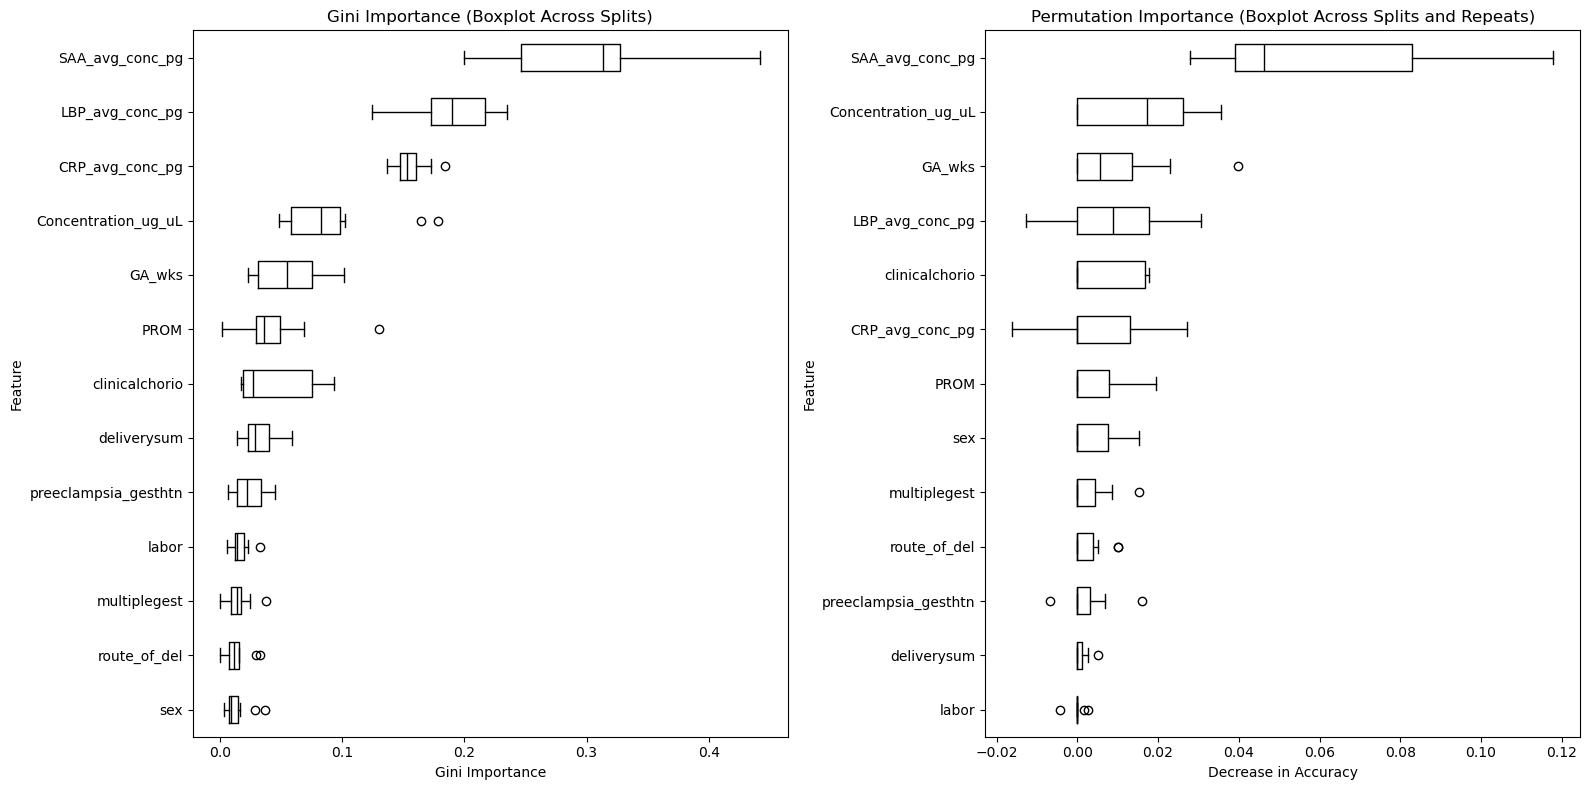

In [42]:
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version

# feature importance lists
gini_importance_list = []
permutation_importance_list = []

# iterate through splits
for i, (train_index, test_index) in enumerate(sss.split(X, Y)):
    # fit rf with parameters from gridsearch
    clf.fit(X.iloc[train_index, :], Y.iloc[train_index])
    best_rf = clf.best_estimator_
    
    # gini importance
    gini_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
    gini_importance_list.append(gini_importances)
    
    # permutation importance
    result = permutation_importance(
        best_rf, X.iloc[train_index, :], Y.iloc[train_index],
        n_repeats=20, random_state=42, n_jobs=-1
    )
    perm_importances = pd.Series(result.importances_mean, index=X.columns)
    permutation_importance_list.append(perm_importances)

# aggregate importances over splits
mean_gini_importances = pd.concat(gini_importance_list, axis=1).mean(axis=1)
mean_permutation_importances = pd.concat(permutation_importance_list, axis=1).mean(axis=1)


# combine importance data across CV splits
gini_importances_all = pd.concat(gini_importance_list, axis=1)  # columns = CV splits
permutation_importances_all = pd.concat(permutation_importance_list, axis=1)  # columns = all repeats

# sort features by mean importance
gini_mean = gini_importances_all.mean(axis=1)
perm_mean = permutation_importances_all.mean(axis=1)
gini_sorted_features = gini_mean.sort_values(ascending=True).index
perm_sorted_features = perm_mean.sort_values(ascending=True).index

# gini plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

gini_importances_all.loc[gini_sorted_features].T.boxplot(vert=False, ax=ax1, color = 'black')
ax1.set_title("Gini Importance (Boxplot Across Splits)")
ax1.set_xlabel("Gini Importance")
ax1.set_ylabel("Feature")
ax1.grid(False)

# permutation plots
permutation_importances_all.loc[perm_sorted_features].T.boxplot(vert=False, ax=ax2, color = 'black', showfliers= True)
ax2.set_title("Permutation Importance (Boxplot Across Splits and Repeats)")
ax2.set_xlabel("Decrease in Accuracy")
ax2.set_ylabel("Feature")
ax2.grid(False)

plt.tight_layout()
plt.show()


plt.savefig('graphs/fig4_ML_importance_WBIO.eps', format='eps', bbox_inches='tight')


In [43]:
permutation_importance_list_df = pd.DataFrame(permutation_importance_list)
permutation_importance_list_df.to_csv('extendeddata/f4b_data.csv', index=True)

<Figure size 640x480 with 0 Axes>

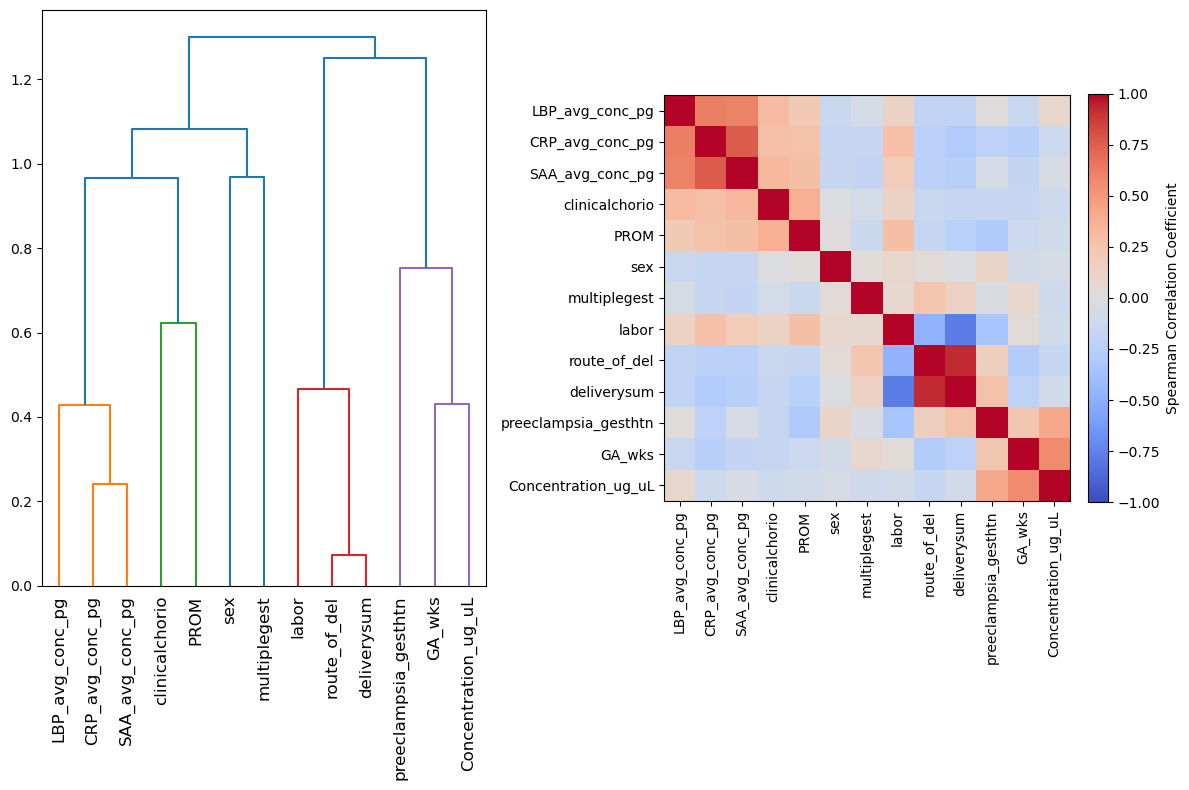

In [44]:
# supplemental figure 2

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ordered_corr = corr[dendro["leaves"], :][:, dendro["leaves"]]
im = ax2.imshow(
    ordered_corr, cmap='coolwarm', vmin=-1, vmax=1  
)
cbar = fig.colorbar(im, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Spearman Correlation Coefficient')

#ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()


plt.savefig('graphs/s2_collinearity_WBIO.eps', format='eps', bbox_inches='tight')
plt.show()

In [45]:
corr_df = pd.DataFrame(corr, index=X.columns, columns=X.columns)
corr_df.to_csv('extendeddata/s2_data.csv', index=True)

In [ ]:
### Figure 5

In [46]:
#using the model to classify presumed sepsis patients into EOS or Control
#ps_notlab['majority_label']= clf.predict(ps_notlab.loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg']])
#ps_notlab['majority_label']= clf.predict(ps_notlab.loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg', 'GA_wks', 'sex', 'multiplegest', 'preeclampsia_gesthtn', 'deliverysum', 'route_of_del', 'labor', 'clinicalchorio', 'PROM']])
ps_notlab['majority_label']= clf.predict(ps_notlab.loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg', 'GA_wks', 'sex', 'multiplegest', 'preeclampsia_gesthtn', 'route_of_del', 'labor', 'deliverysum', 'clinicalchorio', 'PROM', 'Concentration_ug_uL']])

ctrl = ps_notlab[ps_notlab['majority_label']=='Control']


5.403581454840458e-07
4.820311131667432e-07
6.054610957622636e-07


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


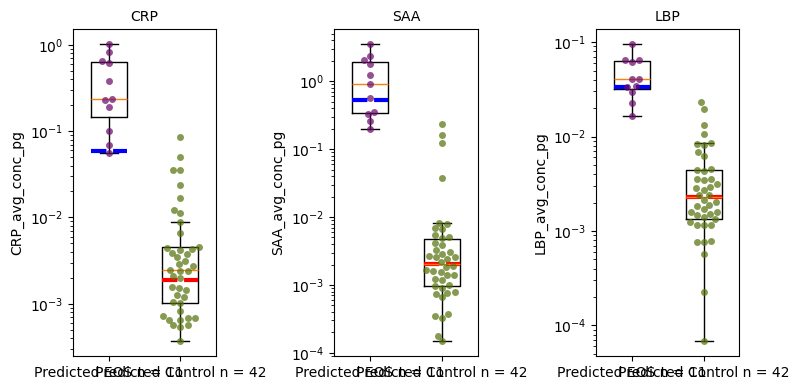

In [47]:
# Boxplot of the 3 proteins for presumed sepsis patients split by the predicted label
sns.set(font_scale=0.3)
plt.style.use('default')

plt.figure(figsize=[8, 4])
colnames = [
    'CRP_avg_conc_pg',
    'SAA_avg_conc_pg',
    'LBP_avg_conc_pg'
]

PG_TO_MG = 1e-9  # Conversion factor from pg to mg
count = 0

for c in range(len(colnames)):
    col = colnames[c]
    count += 1
    ax = plt.subplot(1, 3, count)

    # Apply conversion to mg
    ctrl = ps_notlab[ps_notlab['majority_label'] == 'Control'][col].dropna() * PG_TO_MG
    eos = ps_notlab[ps_notlab['majority_label'] == 'EOS'][col].dropna() * PG_TO_MG
    #pctrl = ps_notlab[ps_notlab['majority_label'] == 'Control']['prob']
    #peos = ps_notlab[ps_notlab['majority_label'] == 'EOS']['prob']
    # Boxplots
    box_ctrl = ax.boxplot(ctrl, positions=[1],
                          labels=[f'Predicted Control n = {ctrl.shape[0]}'],
                          widths=0.5, showfliers=False)
    second_median_ctrl = ctrl_medians[col] # Converted median for Control

    for median in box_ctrl['medians']:
        median_coords = median.get_xydata()
        x0, x1 = median_coords[:, 0]
        ax.plot([x0, x1], [second_median_ctrl, second_median_ctrl],
                color='red', linestyle='--', linewidth=3)

    sns.swarmplot(y=eos, color='#6a0d69', alpha=0.72)
    sns.swarmplot(y=ctrl, x=1, color='#57740e', alpha=0.72)
    #cmap = mpl.get_cmap('coolwarm')
    #sns.swarmplot(y=eos, color=cmap(peos), alpha=0.72)
    #sns.swarmplot(y=ctrl, x=1, color=cmap(pctrl), alpha=0.72)

    box_eos = ax.boxplot(eos, positions=[0],
                         labels=[f'Predicted EOS n = {eos.shape[0]}'],
                         widths=0.5, showfliers=False)
    second_median_eos = eos_medians[col]   # Converted median for EOS

    for median in box_eos['medians']:
        median_coords = median.get_xydata()
        x0, x1 = median_coords[:, 0]
        ax.plot([x0, x1], [second_median_eos, second_median_eos],
                color='blue', linestyle='--', linewidth=3)

    # Set y-axis to log scale
    plt.yscale('log')

    # Mann-Whitney U test
    pval = stats.mannwhitneyu(ctrl, eos).pvalue
    ax.set_title(f'{col.split("_")[0]}', fontsize=10)
    print(pval)

plt.tight_layout()
plt.savefig('graphs/fig5_ps_boxplots_logged.eps', format = 'eps', bbox_inches = 'tight')

plt.show()
plt.close()



In [48]:
f5b_data = ps_notlab[['sample_type_y', 'sample_id', 'majority_label'] + colnames]
#f2c_data = new_df[['sample_type', 'sample_id'] + genes]

f5b_data.to_csv('extendeddata/f5b_data.csv', index=True)

In [49]:
#giving PS new labels of predicted_Control or predicted_EOS
new_labels = []
for sid in tmpdf.index:
    if mesoscale.loc[sid,'sample_type_x'] != 'PS':
        new_labels.append(mesoscale.loc[sid,'sample_type_x'])
    else:
        new_labels.append('predicted_{}'.format(ps_notlab.loc[sid,'majority_label']))

lut = {'EOS': '#7cb0c2', 'Control': '#940043', 'predicted_Control': '#6a0d69', 'predicted_EOS':'#57740e'}
row_colors = pd.Series(new_labels).map(lut)
pd.Series(new_labels).value_counts()

Control              105
predicted_Control     42
EOS                   14
predicted_EOS         11
Name: count, dtype: int64

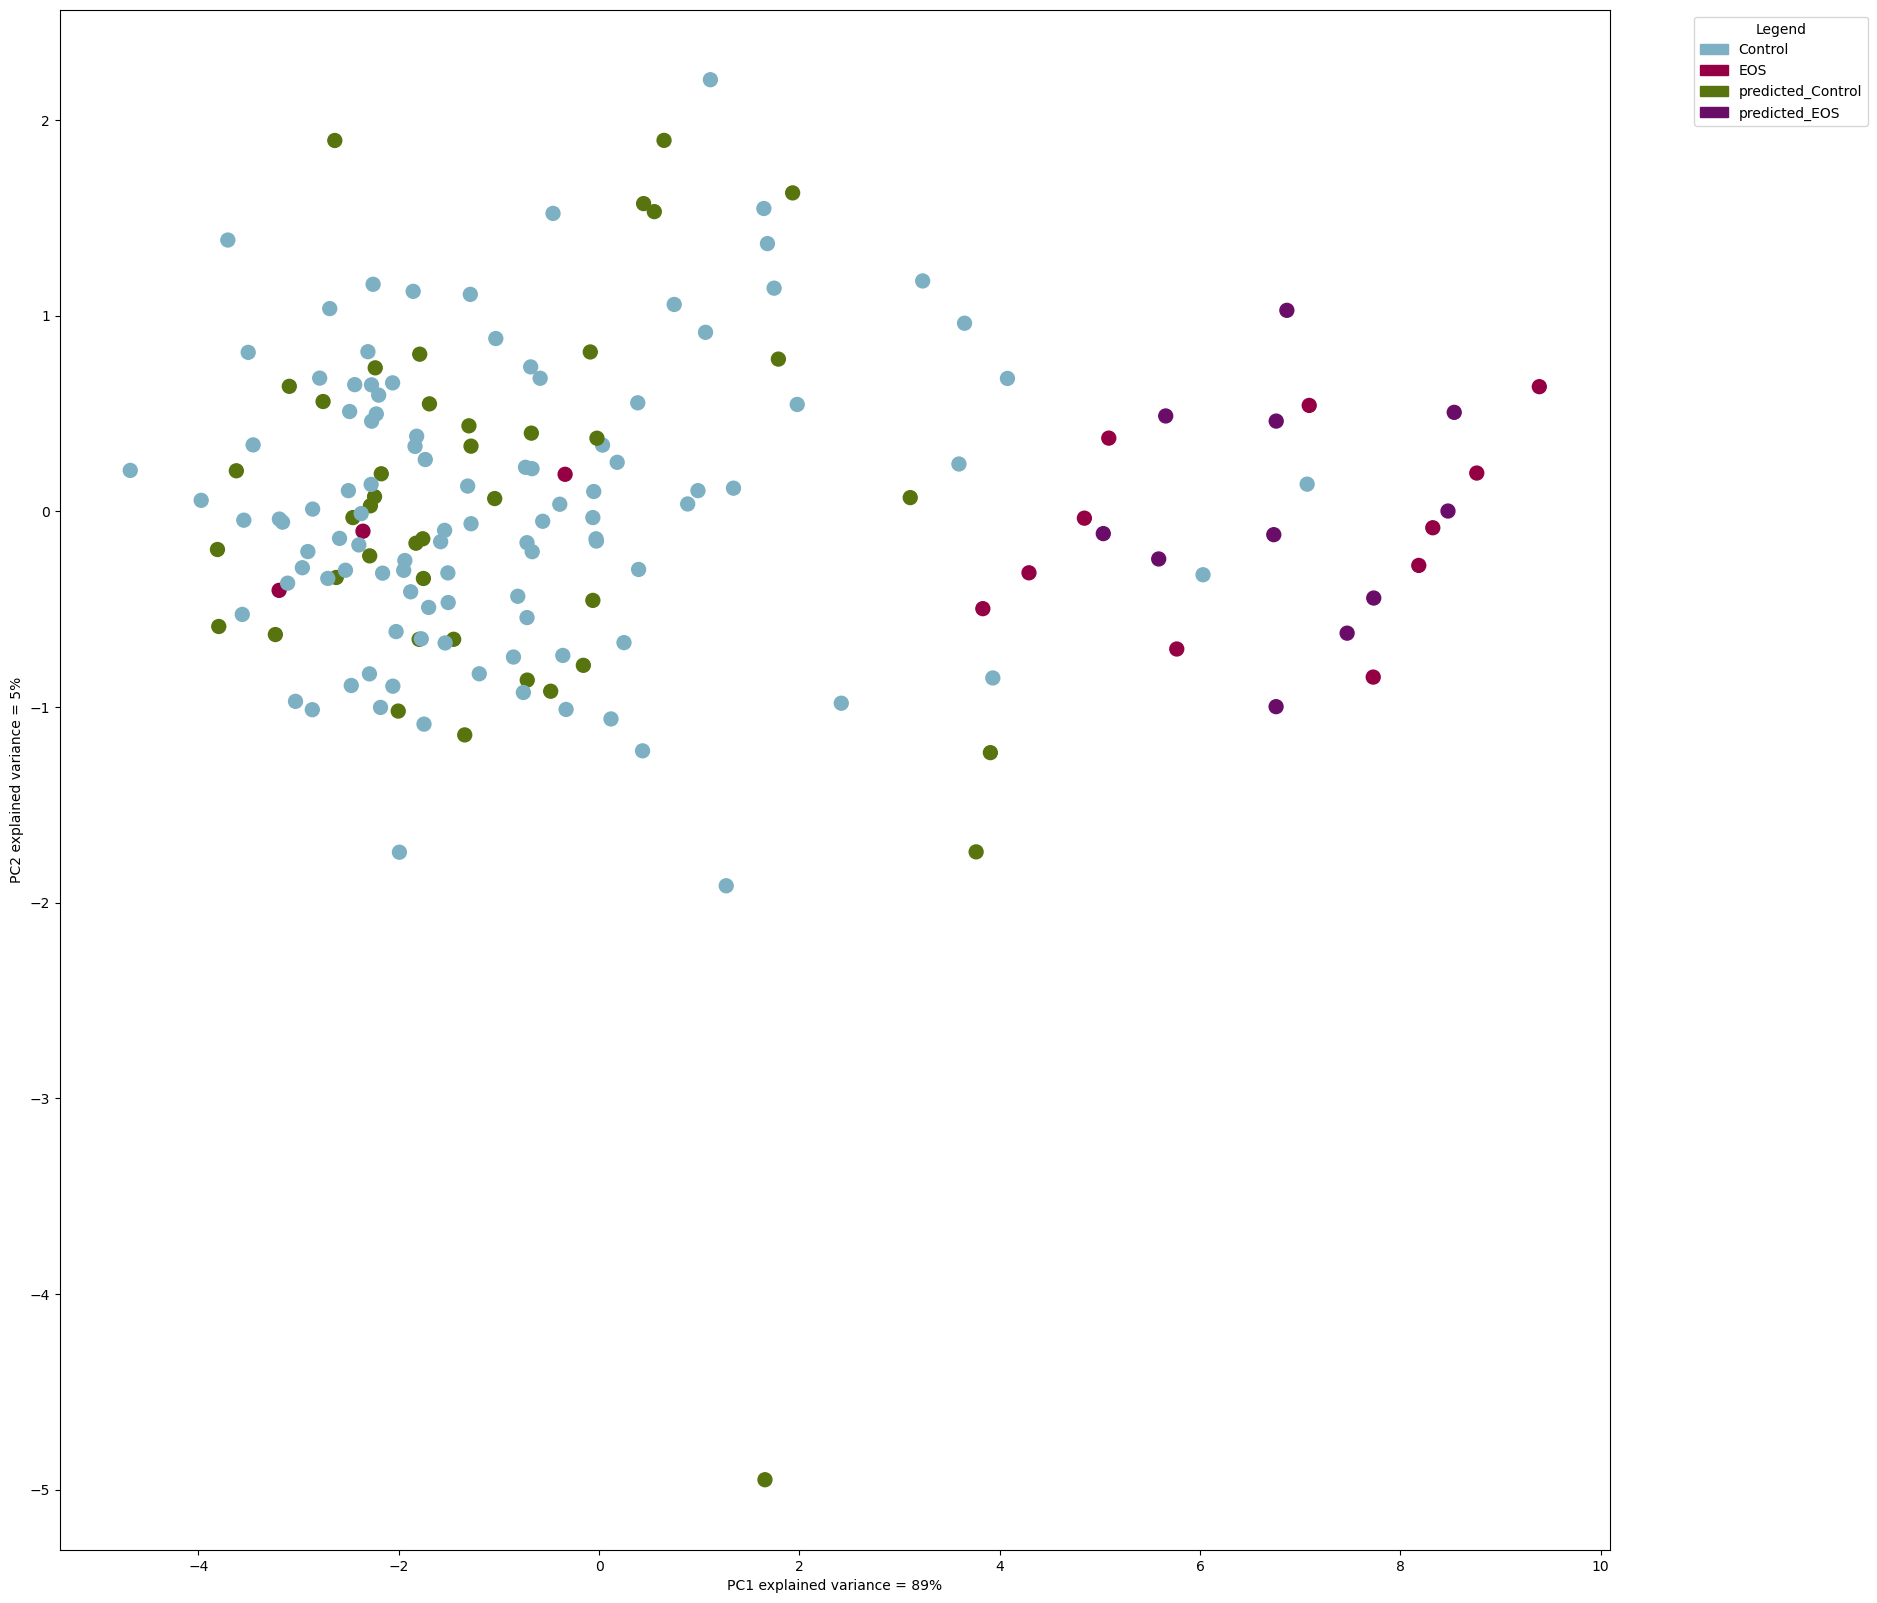

In [50]:
#replotting PCA with presumed sepsis patients and colored by their predicted label
from sklearn.decomposition import PCA
Xbio = df.loc[:,['CRP_avg_conc_pg','SAA_avg_conc_pg', 'LBP_avg_conc_pg', 'GA_wks', 'sex', 'multiplegest', 'preeclampsia_gesthtn', 'route_of_del', 'labor', 'deliverysum', 'clinicalchorio', 'PROM', 'Concentration_ug_uL']]

lut = {'Control': '#7cb0c2', 'EOS': '#940043', 'predicted_Control': '#57740e', 'predicted_EOS':'#6a0d69'}
row_colors = pd.Series(new_labels).map(lut)

sns.set(font_scale=2)

plt.style.use('default')

plt.figure(figsize = [20,20])
pca = PCA(n_components=2)
x_new = pca.fit_transform(tmpdf)
x_new_df = pd.DataFrame(x_new)
x_new_df.index = tmpdf.index

plt.scatter(x_new_df.iloc[:,0], x_new_df.iloc[:,1], color = row_colors, s = 100)
plt.xlabel('PC1 explained variance = {}%'.format(int(pca.explained_variance_ratio_[0]*100)))
plt.ylabel('PC2 explained variance = {}%'.format(int(pca.explained_variance_ratio_[1]*100)))
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in lut.items()]
plt.legend(handles=legend_handles, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()
#for i, txt in enumerate(x_new_df.index):
#    plt.annotate(txt, (x_new_df.iloc[i,0], x_new_df.iloc[i,1]), fontsize = 10)

plt.savefig('graphs/fig5_real_pca_withps_WBIO.eps',format = 'eps',bbox_inches = 'tight')


In [51]:
f5a_data = pd.DataFrame(
    data=x_new,
    columns=['PC1', 'PC2']  
)

f5a_data['sample_id'] = tmpdf.index
f5a_data['new_labels'] = new_labels

f5a_data.to_csv('extendeddata/f5a_data.csv', index=False)
